# Preprocessing
## Steps 
1. Basic preprocessing
    1.1. Remove training scene
    1.2. Ensuring 10+ Events
    1.3. Analysis of Delta Time (to ensure no large time differences between samples)
    1.4. Excluding `II_variant`
2. Blink detection to get true blinks
3. Steering input should not be constant zero.
4. Large calibration issues (systematic deviations from mean value).
7. Timestamps issues: (1. loong differences from a ts to the next; 2 repeated rows with likely same info)
8. Sampling rate calculation and resample



In [1]:
import gc
import glob  
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pathos.pools
from functools import partial
import os
import math
from  matplotlib.ticker import PercentFormatter
sns.set_style("white")
# sns.set_context("notebook")
sns.set_theme(style="ticks", palette="husl")
# set dask dashboard
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from scipy.spatial.transform import Rotation as R
# pd.options.mode.chained_assignment = None  # default='warn'
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.
client

<Client: 'tcp://127.0.0.1:53003' processes=4 threads=12, memory=31.92 GiB>

In [2]:
# Define dtypes to load all uid files
dtypes = {'uid': 'str','dataset': 'str','city_section': 'str','ExperimentalCondition': 'str','EventName': 'object','HitObjectName': 'object','ObjectName_4': 'object','ObjectName_5': 'object', 'EventDuration': 'float64', 'TimeStamp': 'float64'}
# Define the path to the CSV file
# Use the current working directory
dir = os.getcwd()
# Use glob to find all CSV files in the specified directory
data_path = dir + '/Data/'
# file_path = os.path.join(data_folder, file_name)  # Complete path to the file
# load all data
ddf = dd.read_csv(data_path + '*.csv', assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)

In [3]:
ddf


Dask DataFrame Structure:
               timestamp_REF     uid dataset city_section ExperimentalCondition UnixTimeStamp TobiiTimeStamp      FPS RightEyeIsBlinkingWorld RightEyeIsBlinkingLocal LeftEyeIsBlinkingWorld LeftEyeIsBlinkingLocal HmdPosition.x HmdPosition.y HmdPosition.z NoseVector.x NoseVector.y NoseVector.z EyePosWorldCombined.x EyePosWorldCombined.y EyePosWorldCombined.z EyeDirWorldCombined.x EyeDirWorldCombined.y EyeDirWorldCombined.z EyePosLocalCombined.x EyePosLocalCombined.y EyePosLocalCombined.z EyeDirLocalCombined.x EyeDirLocalCombined.y EyeDirLocalCombined.z ObjectName_1 ObjectName_2 ObjectName_3 ObjectName_4 ObjectName_5 HitObjectPosition.x_1 HitObjectPosition.x_2 HitObjectPosition.x_3 HitObjectPosition.x_4 HitObjectPosition.x_5 HitObjectPosition.y_1 HitObjectPosition.y_2 HitObjectPosition.y_3 HitObjectPosition.y_4 HitObjectPosition.y_5 HitObjectPosition.z_1 HitObjectPosition.z_2 HitObjectPosition.z_3 HitObjectPosition.z_4 HitObjectPosition.z_5 HitPointOnObject.x_1 HitPointOnObject.x_2 HitPointOnObject.x_3 HitPointOnObject.x_4 HitPointOnObject.x_5 HitPointOnObject.y_1 HitPointOnObject.y_2 HitPointOnObject.y_3 HitPointOnObject.y_4 HitPointOnObject.y_5 HitPointOnObject.z_1 HitPointOnObject.z_2 HitPointOnObject.z_3 HitPointOnObject.z_4 HitPointOnObject.z_5 distanceToPlayer_1 distanceToPlayer_2 distanceToPlayer_3 distanceToPlayer_4 distanceToPlayer_5 EventName StartofEventTimeStamp EndOfEventTimeStamp EventDuration SuccessfulCompletionState HitObjectName TimeStamp ReceivedInput SteeringInput AcellerationInput BrakeInput TimeStamp_in_sec
npartitions=63                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
                      string  string  string       string                string       float64        float64  float64                    bool                    bool                   bool                   bool       float64       float64       float64      float64      float64      float64               float64               float64               float64               float64               float64               float64               float64               float64               float64               float64               float64               float64       string       string       string       string       string               float64               float64               float64               float64               float64               float64               float64               float64               float64               float64               float64       

In [4]:
from dask.distributed import Client
client = Client()
print("Dask Dashboard is running at:", client.dashboard_link)


c:\Users\erene\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53038 instead
  warnings.warn(


Dask Dashboard is running at: http://127.0.0.1:53038/status


In [5]:
# Run only if you want (computer memory permits) to load all csv file 
from dask.distributed import Client

# Adjust the memory limit per worker
client = Client(memory_limit='28GB')  # Adjust based on your machine's capacity

# COMMENT ABOVE IF ITS THROWING AN ERROR FOR YOU
# df = ddf.compute()


c:\Users\erene\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53081 instead
  warnings.warn(


In [6]:
# Get unique uids from the 'uid' column and convert to a list
unique_uids = ddf['uid'].drop_duplicates().compute().tolist()
unique_uids

2025-02-26 16:43:36,539 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3937714a139b3e31ff8d6f60a3b63a66 initialized by task ('shuffle-transfer-3937714a139b3e31ff8d6f60a3b63a66', 28) executed on worker tcp://127.0.0.1:53111
2025-02-26 16:43:53,896 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3937714a139b3e31ff8d6f60a3b63a66 deactivated due to stimulus 'task-finished-1740584633.8781765'


['0117810eb9634c4f98f842021ee6a595',
 '2fe73e7e2534479aa59aeb91635906aa',
 '68dee417b7c6402e80e3001a8d07ac53',
 '7c0436814ca14e00bfab565cb89f4039',
 'a5e665fb970b4b03a810698a63b3b635',
 'e113171c2c8c48679e92a0e241b31060',
 '47e5b0cb9fca4c5c9748b9e03e63a9a7',
 '56341d0729234d90ae05458aab4b43c4',
 '6f36a58eb7d843a593a01191c53bc0d0',
 '9d21c3cf1fb64f87a7ee9f6612d31768',
 '40ffa04f4781418c946b01206562b124',
 '806565e397a2453d8287d04d059399de',
 'a7da330198d5442d92f4cb9a3ab49a62',
 '0121f5b2f59d434f8beb17bf3e2a80b9',
 '228bdb9398f6492092c45467428bb95a',
 '27ee7a0bfc2840e38225f653232d1487',
 '677eb13e053d46edb23876a1cf070e34',
 'f820d1c1117c4255a529f527c6c82d1f',
 '8fa9f3c28edc4b2a88556096f09ec8cb',
 '91519bcefe1844d595ff7317c00b0351',
 '8c3f910d2ca947e9abe0cf5786c40ed3',
 'e204e48fbca64ed9a9aa05a213dc8381',
 'f767840dc9b94eeabb8d0cfb2a5da57c',
 '29006bddb3e8430582165c73bc7af864',
 'b7f065b7dbbe442485552fa041d44b20',
 '0ed7464df24848a68bcc2dfd1ec58f29',
 '5b086469856442e8abac0651c33e2c8e',
 

In [7]:
len(unique_uids)

171

## 1. Basic preprocessing
### 1.1 Remove TrainingScene

In [8]:
# Retrieve all data for specific uid and remove TrainingScene
# df = ddf[(ddf['uid'] == unique_uids[0]) & (ddf['city_section'] != 'TrainingScene') & (ddf['EventName'] != 'II_variant')].compute()
# Retrieve all data for all uid, remove TrainingScene   

df = ddf[(ddf['city_section'] != 'TrainingScene')].compute()

In [9]:
# Count the amount of unique of Events per uid
complete_events = df.groupby('uid')['EventName'].nunique().sort_values(ascending=True)
complete_events

uid
4a10fec1583843e5b1c82fb74fa7c775     7
b89680ab48514db8bca8fcca1852f36d     8
eadeee63de7f40a4b4375733651d5dd1     9
ccb6fbce179d456c892ce2e029dd7fd1     9
8e03eb1671774d3d9a35f97178902a45     9
                                    ..
7736a53b63874dde915148a2f4f4a753    12
7b1f3e040a654bb7afff67a711e46081    12
7c0436814ca14e00bfab565cb89f4039    12
a710f3de91aa4ab1855aea34eb52a03e    12
ff4288f304e74bbf93aa6508c7df8145    12
Name: EventName, Length: 171, dtype: int64

### 1.2 Ensuring 10+ Events 

In [10]:
# Filter out groups with less than 11 unique events
valid_uids = complete_events[complete_events >= 10].index.to_list()
# Filter the original DataFrame based on valid uids
filtered_df = df[df['uid'].isin(valid_uids)]
filtered_df.head(10)

timestamp_REF                               uid  \
5237  2020-09-26 13:46:07.387864320+00:00  0037b2329de444c18d751b4e79901b39   
5238  2020-09-26 13:46:10.404847616+00:00  0037b2329de444c18d751b4e79901b39   
5239  2020-09-26 13:46:10.415003904+00:00  0037b2329de444c18d751b4e79901b39   
5240  2020-09-26 13:46:10.432984064+00:00  0037b2329de444c18d751b4e79901b39   
5241  2020-09-26 13:46:10.444952320+00:00  0037b2329de444c18d751b4e79901b39   
5242  2020-09-26 13:46:10.467023104+00:00  0037b2329de444c18d751b4e79901b39   
5243  2020-09-26 13:46:10.477894144+00:00  0037b2329de444c18d751b4e79901b39   
5244  2020-09-26 13:46:10.490250240+00:00  0037b2329de444c18d751b4e79901b39   
5245  2020-09-26 13:46:10.500556800+00:00  0037b2329de444c18d751b4e79901b39   
5246  2020-09-26 13:46:10.522168576+00:00  0037b2329de444c18d751b4e79901b39   

          dataset  city_section ExperimentalCondition  UnixTimeStamp  \
5237  EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5238  EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5239  EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5240  EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5241  EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5242  EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5243  EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5244  EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5245  EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5246  EyeTracking  MountainRoad         BaseCondition   1.601128e+09   

      TobiiTimeStamp        FPS  RightEyeIsBlinkingWorld  \
5237      320.263977  90.002266                    False   
5238      336.057007   3.215231                    False   
5239      336.071259   3.554384                    False   
5240      336.089417   3.921189                    False   
5241      336.101135   4.334725                    False   
5242      336.122864   5.292978                    False   
5243      336.134216   5.842119                    False   
5244      336.145996   6.441910                    False   
5245      336.157440   7.099532                    False   
5246      336.178619   8.612434                    False   

      RightEyeIsBlinkingLocal  ...  EndOfEventTimeStamp  EventDuration  \
5237                    False  ...                  NaN            NaN   
5238                    False  ...                  NaN            NaN   
5239                    False  ...                  NaN            NaN   
5240                    False  ...                  NaN            NaN   
5241                    False  ...                  NaN            NaN   
5242                    False  ...                  NaN            NaN   
5243                    False  ...                  NaN            NaN   
5244                    False  ...                  NaN            NaN   
5245                    False  ...                  NaN            NaN   
5246                    False  ...                  NaN            NaN   

      SuccessfulCompletionState  HitObjectName     TimeStamp  ReceivedInput  \
5237                        NaN           <NA>  1.601128e+09           True   
5238                        NaN           <NA>  1.601128e+09           True   
5239                        NaN           <NA>  1.601128e+09           True   
5240                        NaN           <NA>  1.601128e+09           True   
5241                        NaN           <NA>  1.601128e+09           True   
5242                        NaN           <NA>  1.601128e+09           True   
5243                        NaN           <NA>  1.601128e+09           True   
5244                        NaN           <NA>  1.601128e+09           True   
5245                        NaN           <NA>  1.601128e+09           True   
5246                        NaN           <NA>  1.601128e+09           True   

      SteeringInput

### 1.3 Analysis of Delta Time 
We calculate the delta time between datapoints to detect possible data loss or sampling rate issues.

In [11]:
# Since NaN in "EventName" represent moments outside events, we replace them with "OutsideEvent"
filtered_df['EventName'] = filtered_df['EventName'].fillna('NoEvent')
# Group by 'uid' and calculate the difference for 'TimeStamp_in_sec'
filtered_df['TimeDiff_in_sec'] = filtered_df.groupby('uid')['TimeStamp_in_sec'].diff()

In [12]:
filtered_df

timestamp_REF                               uid  \
5237    2020-09-26 13:46:07.387864320+00:00  0037b2329de444c18d751b4e79901b39   
5238    2020-09-26 13:46:10.404847616+00:00  0037b2329de444c18d751b4e79901b39   
5239    2020-09-26 13:46:10.415003904+00:00  0037b2329de444c18d751b4e79901b39   
5240    2020-09-26 13:46:10.432984064+00:00  0037b2329de444c18d751b4e79901b39   
5241    2020-09-26 13:46:10.444952320+00:00  0037b2329de444c18d751b4e79901b39   
...                                     ...                               ...   
100077  2020-09-19 10:31:35.095044608+00:00  ff4288f304e74bbf93aa6508c7df8145   
100078  2020-09-19 10:31:35.116986112+00:00  ff4288f304e74bbf93aa6508c7df8145   
100079  2020-09-19 10:31:35.139722752+00:00  ff4288f304e74bbf93aa6508c7df8145   
100080  2020-09-19 10:31:35.150694400+00:00  ff4288f304e74bbf93aa6508c7df8145   
100081  2020-09-19 10:31:35.172635904+00:00  ff4288f304e74bbf93aa6508c7df8145   

            dataset  city_section ExperimentalCondition  UnixTimeStamp  \
5237    EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5238    EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5239    EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5240    EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
5241    EyeTracking  MountainRoad         BaseCondition   1.601128e+09   
...             ...           ...                   ...            ...   
100077  EyeTracking      Autobahn            FullLoopAR   1.600511e+09   
100078  EyeTracking      Autobahn            FullLoopAR   1.600511e+09   
100079  EyeTracking      Autobahn            FullLoopAR   1.600511e+09   
100080  EyeTracking      Autobahn            FullLoopAR   1.600511e+09   
100081  EyeTracking      Autobahn            FullLoopAR   1.600511e+09   

        TobiiTimeStamp        FPS  RightEyeIsBlinkingWorld  \
5237        320.263977  90.002266                    False   
5238        336.057007   3.215231                    False   
5239        336.071259   3.554384                    False   
5240        336.089417   3.921189                    False   
5241        336.101135   4.334725                    False   
...                ...        ...                      ...   
100077     1277.914185  90.083817                    False   
100078     1277.936523  89.880363                    False   
100079     1277.958374  90.203796                    False   
100080     1277.969727  89.948059                    False   
100081     1277.991943  89.988075                    False   

        RightEyeIsBlinkingLocal  ...  EventDuration  \
5237                      False  ...            NaN   
5238                      False  ...            NaN   
5239                      False  ...            NaN   
5240                      False  ...            NaN   
5241                      False  ...            NaN   
...                         ...  ...            ...   
100077                    False  ...            NaN   
100078                    False  ...            NaN   
100079                    False  ...            NaN   
100080                    False  ...            NaN   
100081                    False  ...            NaN   

        SuccessfulCompletionState  HitObjectName     TimeStamp  ReceivedInput  \
5237                          NaN           <NA>  1.601128e+09           True   
5238                          NaN           <NA>  1.601128e+09           True   
5239                          NaN           <NA>  1.601128e+09           True   
5240                          NaN           <NA>  1.601128e+09           True   
5241                          NaN           <NA>  1.601128e+09           True   
...                           ...            ...           ...            ...   
100077                        NaN           <NA>  1.600511e+09           True   
100078                        NaN           <NA>  1.600511e+09           True   
100079                        NaN

Visualize delta times per uid across time

In [13]:
# Function to save plots for UIDs in batches
def plot_uids_in_batches(filtered_df, batch_size=10):
    unique_uids = filtered_df['uid'].unique()
    num_batches = (len(unique_uids) + batch_size - 1) // batch_size

    for i in range(num_batches):
        batch_uids = unique_uids[i * batch_size:(i + 1) * batch_size]
        
        # Create a DataFrame for the current batch
        batch_df = filtered_df[filtered_df['uid'].isin(batch_uids)]
        
        # Generate the FacetGrid
        g = sns.FacetGrid(batch_df, col='uid', hue='EventName', col_wrap=2, height=4, aspect=1.5)
        g.map_dataframe(sns.scatterplot, x='TimeStamp_in_sec', y='TimeDiff_in_sec')
        g.add_legend()

        # Add titles and labels
        g.set_axis_labels('Time (s)', 'Time Difference (s)')
        g.set_titles(col_template='Participant UID: {col_name}')
        plt.subplots_adjust(top=0.9)

        # Save the plot for the current batch
        # plt.savefig(f"plots/delta_time_per_uid_batch_{i + 1}.jpeg", dpi=500, bbox_inches='tight')
        # plt.savefig(f"plots/delta_time_per_uid_batch_{i + 1}.pdf", dpi=1200, bbox_inches='tight')
        plt.close()  # Close the plot to free up memory before next iteration

# Ensure the output directory exists
os.makedirs("plots", exist_ok=True) 

# Call the function to plot UIDs in batches
# plot_uids_in_batches(filtered_df, batch_size=10)

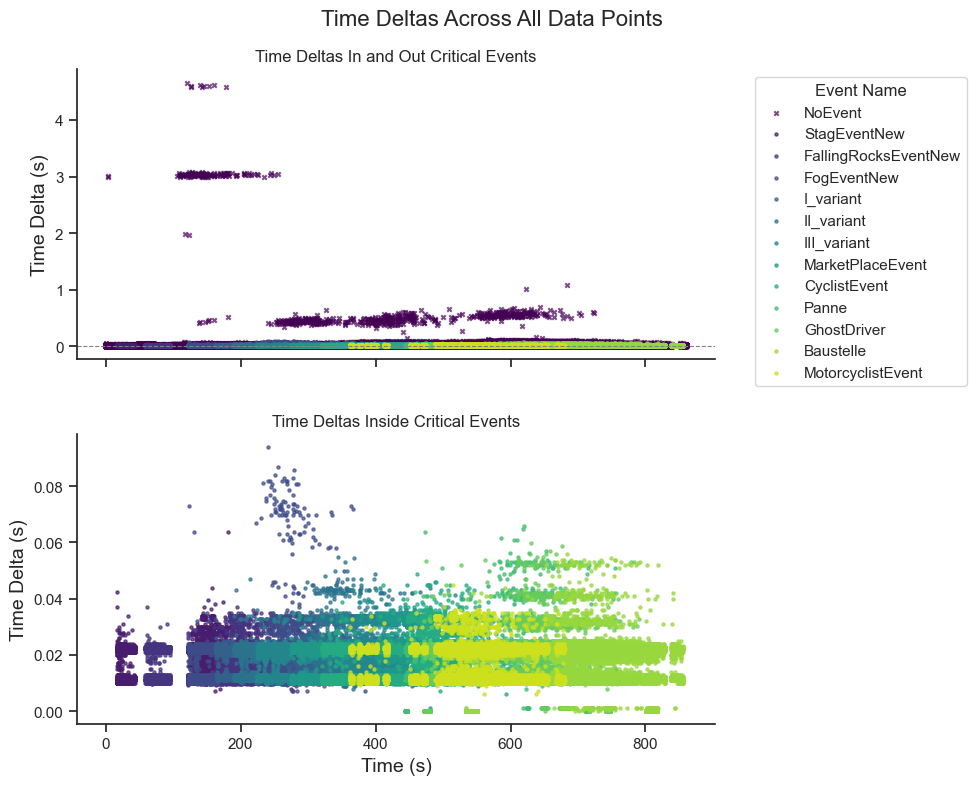

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming filtered_df is your DataFrame that contains 'TimeStamp_in_sec', 'TimeDiff_in_sec', and 'EventName'

# Create a color map based on unique EventNames
unique_events = filtered_df['EventName'].unique()
colors = plt.colormaps['viridis']  # Updated way to get the colormap
num_events = len(unique_events)

# Create a figure for the scatter plot
fig, ax = plt.subplots(2,1,figsize=(10, 8), sharex=True)
fig.suptitle('Time Deltas Across All Data Points', fontsize=16)
# Scatter plot, we will map colors based on EventName
for i, event in enumerate(unique_events):
    marker='o'
    s = 5
    if event == 'NoEvent':
        marker='x'
        s = 10
    event_data = filtered_df[filtered_df['EventName'] == event]
    ax[0].scatter(event_data['TimeStamp_in_sec'], 
                event_data['TimeDiff_in_sec'], 
                color=colors(i / num_events),  # Normalize index to [0, 1] for colormap
                label=event, 
                s=s,  # Marker size
                marker = marker,
                alpha=0.7)  # Transparency
    if event != 'NoEvent':
         ax[1].scatter(event_data['TimeStamp_in_sec'], 
                event_data['TimeDiff_in_sec'], 
                color=colors(i / num_events),  # Normalize index to [0, 1] for colormap
                label=event, 
                s=5,  # Marker size
                alpha=0.7)  # Transparency

# Adding titles and labels

ax[0].set_ylabel('Time Delta (s)', fontsize=14)
ax[0].set_title('Time Deltas In and Out Critical Events')
ax[1].set_xlabel('Time (s)', fontsize=14)
ax[1].set_ylabel('Time Delta (s)', fontsize=14)
ax[1].set_title('Time Deltas Inside Critical Events')
# Adding a horizontal line at y=0 for reference (optional)
ax[0].axhline(0, color='grey', linestyle='--', linewidth=0.8)

# Display the legend
ax[0].legend(title='Event Name', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
# Show the plot
plt.tight_layout()  # Adjust layout to fit labels and title
# plt.savefig(f"plots/delta_time.jpeg", dpi=500, bbox_inches='tight')
# plt.savefig(f"plots/delta_time.pdf", dpi=1200, bbox_inches='tight')
plt.show()

## 2. Detecting eye blinks
This step we will perform in original dataset with original sampling rate. 
<p> ⚠️Note: <span style="color:orange"> This generalizes into a function for all participants.</p>


### 2.1 Label blinks

In [15]:
# Create a condition to detect blinks
# A blink is defined as any entry with all eye position coordinates equal to zero
filtered_df['Blink'] = (
    ((filtered_df['EyeDirLocalCombined.x'] == 0) & 
      (filtered_df['EyeDirLocalCombined.y'] == 0) & 
      (filtered_df['EyeDirLocalCombined.z'] == 0)) | # or
    ((filtered_df['EyePosLocalCombined.x'] == 0) &  
      (filtered_df['EyePosLocalCombined.y'] == 0) &  
      (filtered_df['EyePosLocalCombined.z'] == 0)) | # or
    ((filtered_df['EyeDirWorldCombined.x'] == 0) & 
      (filtered_df['EyeDirWorldCombined.y'] == 0) &  
      (filtered_df['EyeDirWorldCombined.z'] == 0)) | # or
    ((filtered_df['EyePosWorldCombined.x'] == 0) & 
      (filtered_df['EyePosWorldCombined.y'] == 0) &  
      (filtered_df['EyePosWorldCombined.z'] == 0)) 
)

In [16]:
filtered_df.tail(10)

timestamp_REF                               uid  \
100072  2020-09-19 10:31:34.995785216+00:00  ff4288f304e74bbf93aa6508c7df8145   
100073  2020-09-19 10:31:35.017726464+00:00  ff4288f304e74bbf93aa6508c7df8145   
100074  2020-09-19 10:31:35.040190720+00:00  ff4288f304e74bbf93aa6508c7df8145   
100075  2020-09-19 10:31:35.062131968+00:00  ff4288f304e74bbf93aa6508c7df8145   
100076  2020-09-19 10:31:35.073102592+00:00  ff4288f304e74bbf93aa6508c7df8145   
100077  2020-09-19 10:31:35.095044608+00:00  ff4288f304e74bbf93aa6508c7df8145   
100078  2020-09-19 10:31:35.116986112+00:00  ff4288f304e74bbf93aa6508c7df8145   
100079  2020-09-19 10:31:35.139722752+00:00  ff4288f304e74bbf93aa6508c7df8145   
100080  2020-09-19 10:31:35.150694400+00:00  ff4288f304e74bbf93aa6508c7df8145   
100081  2020-09-19 10:31:35.172635904+00:00  ff4288f304e74bbf93aa6508c7df8145   

            dataset city_section ExperimentalCondition  UnixTimeStamp  \
100072  EyeTracking     Autobahn            FullLoopAR   1.600511e+09   
100073  EyeTracking     Autobahn            FullLoopAR   1.600511e+09   
100074  EyeTracking     Autobahn            FullLoopAR   1.600511e+09   
100075  EyeTracking     Autobahn            FullLoopAR   1.600511e+09   
100076  EyeTracking     Autobahn            FullLoopAR   1.600511e+09   
100077  EyeTracking     Autobahn            FullLoopAR   1.600511e+09   
100078  EyeTracking     Autobahn            FullLoopAR   1.600511e+09   
100079  EyeTracking     Autobahn            FullLoopAR   1.600511e+09   
100080  EyeTracking     Autobahn            FullLoopAR   1.600511e+09   
100081  EyeTracking     Autobahn            FullLoopAR   1.600511e+09   

        TobiiTimeStamp        FPS  RightEyeIsBlinkingWorld  \
100072     1277.814453  89.869049                    False   
100073     1277.836548  89.970245                    False   
100074     1277.858887  89.829788                    False   
100075     1277.880737  90.124176                    False   
100076     1277.891968  90.020653                    False   
100077     1277.914185  90.083817                    False   
100078     1277.936523  89.880363                    False   
100079     1277.958374  90.203796                    False   
100080     1277.969727  89.948059                    False   
100081     1277.991943  89.988075                    False   

        RightEyeIsBlinkingLocal  ...  SuccessfulCompletionState  \
100072                    False  ...                        NaN   
100073                    False  ...                        NaN   
100074                    False  ...                        NaN   
100075                    False  ...                        NaN   
100076                    False  ...                        NaN   
100077                    False  ...                        NaN   
100078                    False  ...                        NaN   
100079                    False  ...                        NaN   
100080                    False  ...                        NaN   
100081                    False  ...                        NaN   

        HitObjectName     TimeStamp  ReceivedInput  SteeringInput  \
100072           <NA>  1.600511e+09           True      -0.007354   
100073           <NA>  1.600511e+09           True      -0.007354   
100074           <NA>  1.600511e+09           True      -0.007354   
100075           <NA>  1.600511e+09           True      -0.007354   
100076           <NA>  1.600511e+09           True      -0.007354   
100077           <NA>  1.600511e+09           True      -0.007354   
100078           <NA>  1.600511e+09           True      -0.007354   
100079           <NA>  1.600511e+09           True      -0.007354   
100080           <NA>  1.600511e+09           True      -0.007354   
100081           <NA>  1.600511e+09           True      -0.007354   

        AcellerationInput  BrakeInput  TimeStamp_in_sec  TimeDiff_in_sec  \
100072                0.0         0.0        730.217672         0.021940   
1

### 2.2 Calculate blink durations

In [17]:
# unique_uids = filtered_df["uid"].unique()
# # Convert to DataFrame
# unique_uids_df = pd.DataFrame(unique_uids, columns=["uid"])
# 
# # Sample 4 random UIDs
# sampled_uids = unique_uids_df.sample(n=2)["uid"].tolist()
# print(f"Working with {sampled_uids}")
# df = filtered_df[(filtered_df['uid'].isin(sampled_uids))]
# df

In [18]:
# Initialize an empty DataFrame to store all participants' blink durations
blinks_df = pd.DataFrame()

# Initialize a column to hold blink duration information
filtered_df['BlinkDuration'] = np.nan
# New column for the entire range of each identified blink
filtered_df['BlinkDurationsLong'] = np.nan  

# Calculate blink durations for each uid
for uid in filtered_df['uid'].unique():
    # Filter uid subset
    df_uid = filtered_df[filtered_df['uid'] == uid] 
    # Identify where blinks start and end
    blink_starts = df_uid['Blink'] & ~df_uid['Blink'].shift(1).fillna(False)  # Blink starts
    blink_ends = df_uid['Blink'] & ~df_uid['Blink'].shift(-1).fillna(False)   # Blink ends

    # Calculate the durations
    blink_times = df_uid[blink_starts]['TimeStamp_in_sec']
    durations = df_uid[blink_ends]['TimeStamp_in_sec'].reset_index(drop=True) - blink_times.reset_index(drop=True)

    # Update the BlinkDuration column to contain durations at blink start in the df_uid
    for start_index, duration in zip(blink_times.index, durations):
        df_uid.at[start_index, 'BlinkDuration'] = duration
        
        # Fill BlinkDurationsLong for the entire range of this identified blink
        end_index = df_uid.index[df_uid['TimeStamp_in_sec'] >= df_uid.at[start_index, 'TimeStamp_in_sec'] + duration].min()
        if not pd.isna(end_index):  # If end_index is valid
            df_uid.loc[start_index:end_index, 'BlinkDurationsLong'] = duration
    
    # Store uid data in blinks_df
    blinks_df = pd.concat([blinks_df, df_uid], ignore_index=True)

C:\Users\erene\AppData\Local\Temp\ipykernel_15516\700938874.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  blink_starts = df_uid['Blink'] & ~df_uid['Blink'].shift(1).fillna(False)  # Blink starts
C:\Users\erene\AppData\Local\Temp\ipykernel_15516\700938874.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  blink_ends = df_uid['Blink'] & ~df_uid['Blink'].shift(-1).fillna(False)   # Blink ends
C:\Users\erene\AppData\Local\Temp\ipykernel_15516\700938874.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and

In [19]:
# Filter the DataFrame to retain only the rows where blinks occurred
blink_durations_df = blinks_df[blinks_df['BlinkDuration'] > 0]
blink_durations_df

timestamp_REF  \
219      2020-09-26 13:46:14.024678656+00:00   
279      2020-09-26 13:46:15.075250688+00:00   
500      2020-09-26 13:46:18.886145792+00:00   
904      2020-09-26 13:46:26.004504832+00:00   
1015     2020-09-26 13:46:28.014270976+00:00   
...                                      ...   
5290544  2020-09-19 10:31:13.795443968+00:00   
5290759  2020-09-19 10:31:17.559305216+00:00   
5290960  2020-09-19 10:31:21.090524160+00:00   
5291060  2020-09-19 10:31:22.901095168+00:00   
5291694  2020-09-19 10:31:34.095165952+00:00   

                                      uid      dataset  city_section  \
219      0037b2329de444c18d751b4e79901b39  EyeTracking  MountainRoad   
279      0037b2329de444c18d751b4e79901b39  EyeTracking  MountainRoad   
500      0037b2329de444c18d751b4e79901b39  EyeTracking  MountainRoad   
904      0037b2329de444c18d751b4e79901b39  EyeTracking  MountainRoad   
1015     0037b2329de444c18d751b4e79901b39  EyeTracking  MountainRoad   
...                                   ...          ...           ...   
5290544  ff4288f304e74bbf93aa6508c7df8145  EyeTracking      Autobahn   
5290759  ff4288f304e74bbf93aa6508c7df8145  EyeTracking      Autobahn   
5290960  ff4288f304e74bbf93aa6508c7df8145  EyeTracking      Autobahn   
5291060  ff4288f304e74bbf93aa6508c7df8145  EyeTracking      Autobahn   
5291694  ff4288f304e74bbf93aa6508c7df8145  EyeTracking      Autobahn   

        ExperimentalCondition  UnixTimeStamp  TobiiTimeStamp        FPS  \
219             BaseCondition   1.601128e+09             0.0  87.971024   
279             BaseCondition   1.601128e+09             0.0  89.866661   
500             BaseCondition   1.601128e+09             0.0  90.122238   
904             BaseCondition   1.601128e+09             0.0  90.355247   
1015            BaseCondition   1.601128e+09             0.0  90.128319   
...                       ...            ...             ...        ...   
5290544            FullLoopAR   1.600511e+09             0.0  88.659576   
5290759            FullLoopAR   1.600511e+09             0.0  85.059494   
5290960            FullLoopAR   1.600511e+09             0.0  90.091698   
5291060            FullLoopAR   1.600511e+09             0.0  90.255493   
5291694            FullLoopAR   1.600511e+09             0.0  90.020195   

         RightEyeIsBlinkingWorld  RightEyeIsBlinkingLocal  ...     TimeStamp  \
219                        False                    False  ...  1.601128e+09   
279                        False                    False  ...  1.601128e+09   
500                        False                    False  ...  1.601128e+09   
904                        False                    False  ...  1.601128e+09   
1015                       False                    False  ...  1.601128e+09   
...                          ...                      ...  ...           ...   
5290544                    False                    False  ...  1.600511e+09   
5290759                    False                    False  ...  1.600511e+09   
5290960                    False                    False  ...  1.600511e+09   
5291060                    False                    False  ...  1.600511e+09   
5291694                    False                    False  ...  1.600511e+09   

         ReceivedInput  SteeringInput  AcellerationInput  BrakeInput  \
219               True      -0.005491                0.0         0.0   
279               True      -0.005949                0.0         0.0   
500               True      -0.005032                0.0         0.0   
904               True       0.252965                0.0         0.0   
1015              True      -0.051466                0.0         0.0   
...                ...            ...                ...         ...   
5290544          False       0.000000                0.0         0.0   
5290759           True       0.002252                0.0         0.0   
5290960           True       0.000389                0.0         0.0   
5291060

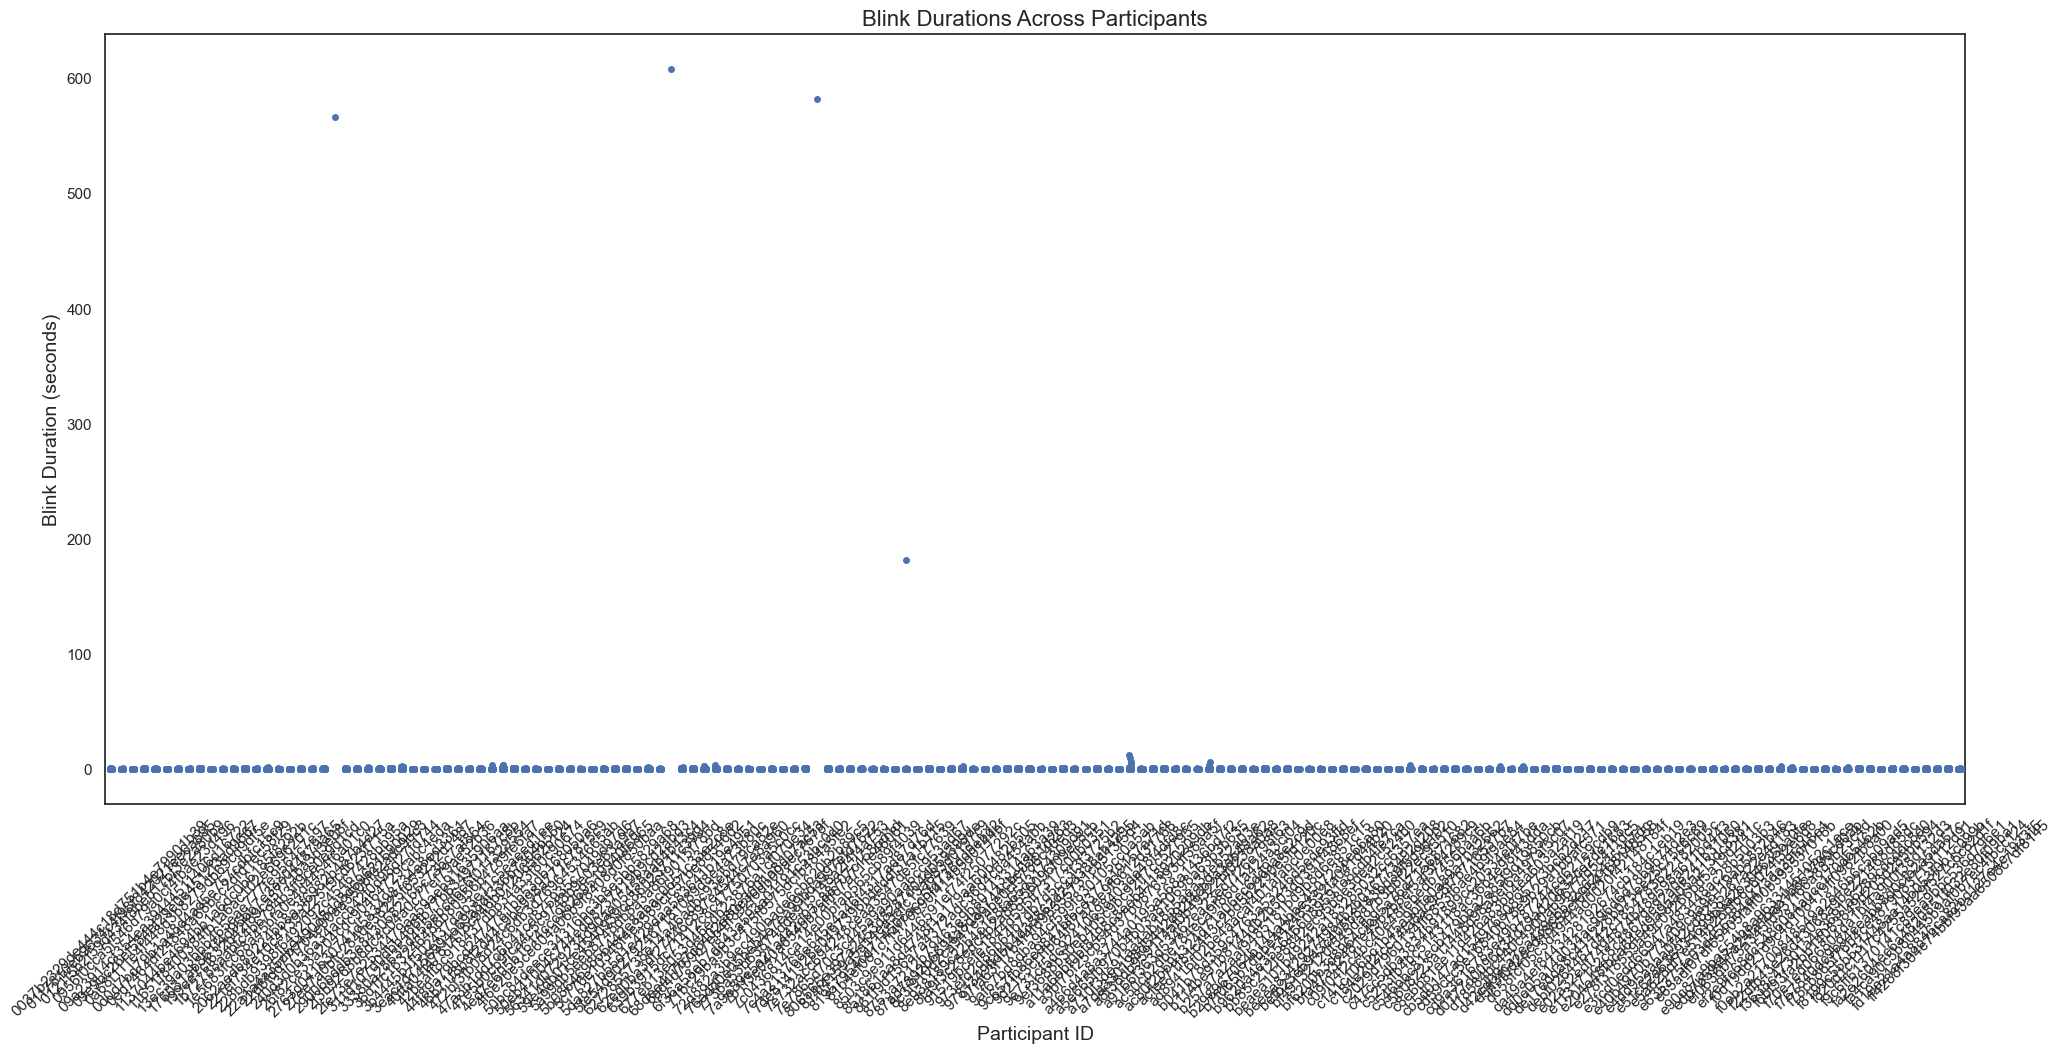

In [20]:
# Set the visual style
sns.set(style="white")

# Create a boxplot for blink durations across participants
fig, ax = plt.subplots(figsize=(24,10))
sns.stripplot(x='uid', y='BlinkDuration', data=blink_durations_df)

# Add title and labels
plt.title('Blink Durations Across Participants', fontsize=16)
plt.xlabel('Participant ID', fontsize=14)
plt.ylabel('Blink Duration (seconds)', fontsize=14)
plt.xticks(rotation=45)
plt.show()

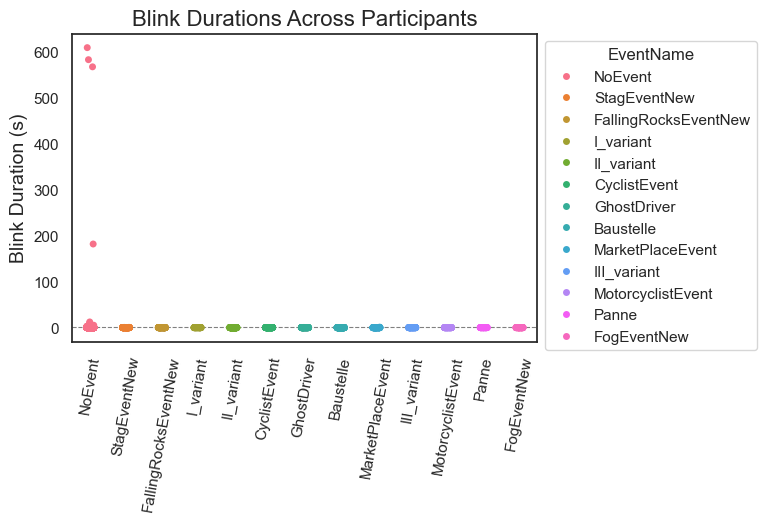

In [21]:
# Set the visual style
sns.set(style="white")
# Create a boxplot for blink durations across participants
# plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(6,4))
sns.stripplot(x='EventName', y='BlinkDuration', data=blink_durations_df, hue='EventName',legend=True)
# Add title and labels
plt.title('Blink Durations Across Participants', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('Blink Duration (s)', fontsize=14)
plt.xticks(rotation=80)
ax.axhline(1, color='grey', linestyle='--', linewidth=0.8)
sns.move_legend(ax,  "upper left", bbox_to_anchor=(1, 1))
# plt.savefig(f"Plots/blink_durations_across_participants" +'.jpeg', dpi=500, bbox_inches='tight')
plt.show()

In [22]:
# Group by uid and count the total blinks 
blink_durations_summary = blink_durations_df.groupby(['uid','EventName'])['BlinkDuration'].count().reset_index()
blink_durations_summary

uid             EventName  BlinkDuration
0     0037b2329de444c18d751b4e79901b39             Baustelle              3
1     0037b2329de444c18d751b4e79901b39          CyclistEvent              2
2     0037b2329de444c18d751b4e79901b39  FallingRocksEventNew              1
3     0037b2329de444c18d751b4e79901b39           GhostDriver              1
4     0037b2329de444c18d751b4e79901b39            II_variant              4
...                                ...                   ...            ...
1115  ff4288f304e74bbf93aa6508c7df8145             Baustelle              1
1116  ff4288f304e74bbf93aa6508c7df8145           GhostDriver              1
1117  ff4288f304e74bbf93aa6508c7df8145             I_variant              1
1118  ff4288f304e74bbf93aa6508c7df8145               NoEvent            100
1119  ff4288f304e74bbf93aa6508c7df8145          StagEventNew              3

[1120 rows x 3 columns]

### 2.3 Excluded UIDs 
* `22d6fdd77f704e00aa350bf02adc9bc3` recording issues for EyeLocal variables for the entire experiment duration, there is still data for EyeWorld
* `5fe54d902792467181089d8e4a73b80c` recording issues for EyeLocal variables for the entire experiment duration, there is still data for EyeWorld
* `7b1f3e040a654bb7afff67a711e46081` recording issues for EyeLocal variables for the entire experiment duration, there is still data for EyeWorld
* `81957954cd71450cacc5fd738dd9ebd2` one instance of recording issues at end of event (duration = 181.6 s); no EyeWorld or local after second 624.18

In [23]:
# Filter uids with > 10 s blink durations suggesting recording issues
blink_durations_df[blink_durations_df['BlinkDuration'] > 4]

timestamp_REF  \
627106   2020-11-27 11:48:47.197136640+00:00   
1584714  2020-10-20 07:12:59.042854400+00:00   
1999973  2020-10-21 07:34:19.164723200+00:00   
2282009  2020-10-15 09:19:47.923995392+00:00   
2921267  2020-09-19 10:29:24.774363904+00:00   
2921732  2020-09-19 10:29:34.002650112+00:00   
2923293  2020-09-19 10:30:01.256682752+00:00   
2925051  2020-09-19 10:30:32.398677504+00:00   
3138999  2020-10-19 09:14:14.087457536+00:00   

                                      uid      dataset  city_section  \
627106   22d6fdd77f704e00aa350bf02adc9bc3  EyeTracking  MountainRoad   
1584714  5fe54d902792467181089d8e4a73b80c  EyeTracking  MountainRoad   
1999973  7b1f3e040a654bb7afff67a711e46081  EyeTracking  MountainRoad   
2282009  81957954cd71450cacc5fd738dd9ebd2  EyeTracking   CountryRoad   
2921267  a3bf7bf25cb54d37b0876393df38aa5f  EyeTracking      Autobahn   
2921732  a3bf7bf25cb54d37b0876393df38aa5f  EyeTracking      Autobahn   
2923293  a3bf7bf25cb54d37b0876393df38aa5f  EyeTracking      Autobahn   
2925051  a3bf7bf25cb54d37b0876393df38aa5f  EyeTracking      Autobahn   
3138999  ac50cb2dbe784eca9f86d1a424a3cf04  EyeTracking   CountryRoad   

        ExperimentalCondition  UnixTimeStamp  TobiiTimeStamp        FPS  \
627106          BaseCondition   1.606478e+09      738.968506  90.238945   
1584714               HUDOnly   1.603178e+09      913.174011  87.137024   
1999973               HUDOnly   1.603266e+09      456.305481  90.032639   
2282009         BaseCondition   1.602754e+09        0.000000  89.926857   
2921267            FullLoopAR   1.600511e+09        0.000000  89.497147   
2921732            FullLoopAR   1.600511e+09        0.000000  85.589661   
2923293            FullLoopAR   1.600511e+09        0.000000  46.640926   
2925051            FullLoopAR   1.600511e+09        0.000000  89.746658   
3138999               HUDOnly   1.603099e+09        0.000000  89.898689   

         RightEyeIsBlinkingWorld  RightEyeIsBlinkingLocal  ...     TimeStamp  \
627106                     False                    False  ...  1.606478e+09   
1584714                    False                    False  ...  1.603178e+09   
1999973                    False                    False  ...  1.603266e+09   
2282009                    False                    False  ...  1.602754e+09   
2921267                    False                    False  ...  1.600511e+09   
2921732                    False                    False  ...  1.600511e+09   
2923293                    False                    False  ...  1.600511e+09   
2925051                    False                    False  ...  1.600511e+09   
3138999                    False                    False  ...  1.603099e+09   

         ReceivedInput  SteeringInput  AcellerationInput  BrakeInput  \
627106            True       0.041141                0.0         0.0   
1584714           True      -0.072209                0.0         0.0   
1999973           True      -0.018474                0.0         0.0   
2282009           True      -0.025866                0.0         0.0   
2921267           True      -0.017527                0.0         0.0   
2921732           True       0.073125                0.0         0.0   
2923293           True      -0.028646                0.0         0.0   
2925051           True      -0.058767                0.0         0.0   
3138999           True      -0.006407                0.0         0.0   

         TimeStamp_in_sec  TimeDiff_in_sec  Blink  BlinkDuration  \
627106         257.325680              NaN   True     566.508119   
1584714        149.891958              NaN   True     608.189089   
1999973        141.644706              NaN   True     582.040724   
2282009        624.184447         0.022939   True     181.661404   
2921267        626.140071         0.010970   True       5.186186   
2921732        635.368358         0.022905   True      12.373268   
2923293        662.622390         0.021942   True       6.275292   
2925051     

In [24]:
# Visually inspect uid suggesting recording issues
one_excluded = blinks_df[blinks_df['uid'] == '81957954cd71450cacc5fd738dd9ebd2']
one_excluded

timestamp_REF  \
2260423  2020-10-15 09:13:06.159353088+00:00   
2260424  2020-10-15 09:13:09.185543936+00:00   
2260425  2020-10-15 09:13:09.195078656+00:00   
2260426  2020-10-15 09:13:09.218668032+00:00   
2260427  2020-10-15 09:13:09.240132864+00:00   
...                                      ...   
2292122  2020-10-15 09:22:49.509602048+00:00   
2292123  2020-10-15 09:22:49.519575040+00:00   
2292124  2020-10-15 09:22:49.540519680+00:00   
2292125  2020-10-15 09:22:49.563459584+00:00   
2292126  2020-10-15 09:22:49.585399552+00:00   

                                      uid      dataset  city_section  \
2260423  81957954cd71450cacc5fd738dd9ebd2  EyeTracking  MountainRoad   
2260424  81957954cd71450cacc5fd738dd9ebd2  EyeTracking  MountainRoad   
2260425  81957954cd71450cacc5fd738dd9ebd2  EyeTracking  MountainRoad   
2260426  81957954cd71450cacc5fd738dd9ebd2  EyeTracking  MountainRoad   
2260427  81957954cd71450cacc5fd738dd9ebd2  EyeTracking  MountainRoad   
...                                   ...          ...           ...   
2292122  81957954cd71450cacc5fd738dd9ebd2  EyeTracking      Autobahn   
2292123  81957954cd71450cacc5fd738dd9ebd2  EyeTracking      Autobahn   
2292124  81957954cd71450cacc5fd738dd9ebd2  EyeTracking      Autobahn   
2292125  81957954cd71450cacc5fd738dd9ebd2  EyeTracking      Autobahn   
2292126  81957954cd71450cacc5fd738dd9ebd2  EyeTracking      Autobahn   

        ExperimentalCondition  UnixTimeStamp  TobiiTimeStamp        FPS  \
2260423         BaseCondition   1.602753e+09      275.820557  90.025101   
2260424         BaseCondition   1.602753e+09      385.974091   3.204663   
2260425         BaseCondition   1.602753e+09      385.987640   3.543647   
2260426         BaseCondition   1.602753e+09      386.010529   4.333445   
2260427         BaseCondition   1.602753e+09      386.032318   5.291227   
...                       ...            ...             ...        ...   
2292122         BaseCondition   1.602754e+09        0.000000  89.286369   
2292123         BaseCondition   1.602754e+09        0.000000  89.112610   
2292124         BaseCondition   1.602754e+09        0.000000  90.635628   
2292125         BaseCondition   1.602754e+09        0.000000  89.476051   
2292126         BaseCondition   1.602754e+09        0.000000  90.241333   

         RightEyeIsBlinkingWorld  RightEyeIsBlinkingLocal  ...     TimeStamp  \
2260423                    False                    False  ...  1.602753e+09   
2260424                    False                    False  ...  1.602753e+09   
2260425                    False                    False  ...  1.602753e+09   
2260426                    False                    False  ...  1.602753e+09   
2260427                    False                    False  ...  1.602753e+09   
...                          ...                      ...  ...           ...   
2292122                    False                    False  ...  1.602754e+09   
2292123                    False                    False  ...  1.602754e+09   
2292124                    False                    False  ...  1.602754e+09   
2292125                    False                    False  ...  1.602754e+09   
2292126                    False                    False  ...  1.602754e+09   

         ReceivedInput  SteeringInput  AcellerationInput  BrakeInput  \
2260423           True      -0.057393                0.0         0.0   
2260424           True      -0.010592                0.0         0.0   
2260425           True      -0.010592                0.0         0.0   
2260426           True      -0.010592                0.0         0.0   
2260427           True      -0.010592                0.0         0.0   
...                ...            ...                ...         ...   
2292122           True       0.003627                0.0         0.0   
2292123           True       0.003627                0.0         0.0   
2292124           True       0.003627                0.0         0.0   
2292125

<Axes: xlabel='TimeStamp_in_sec', ylabel='EyeDirWorldCombined.x'>

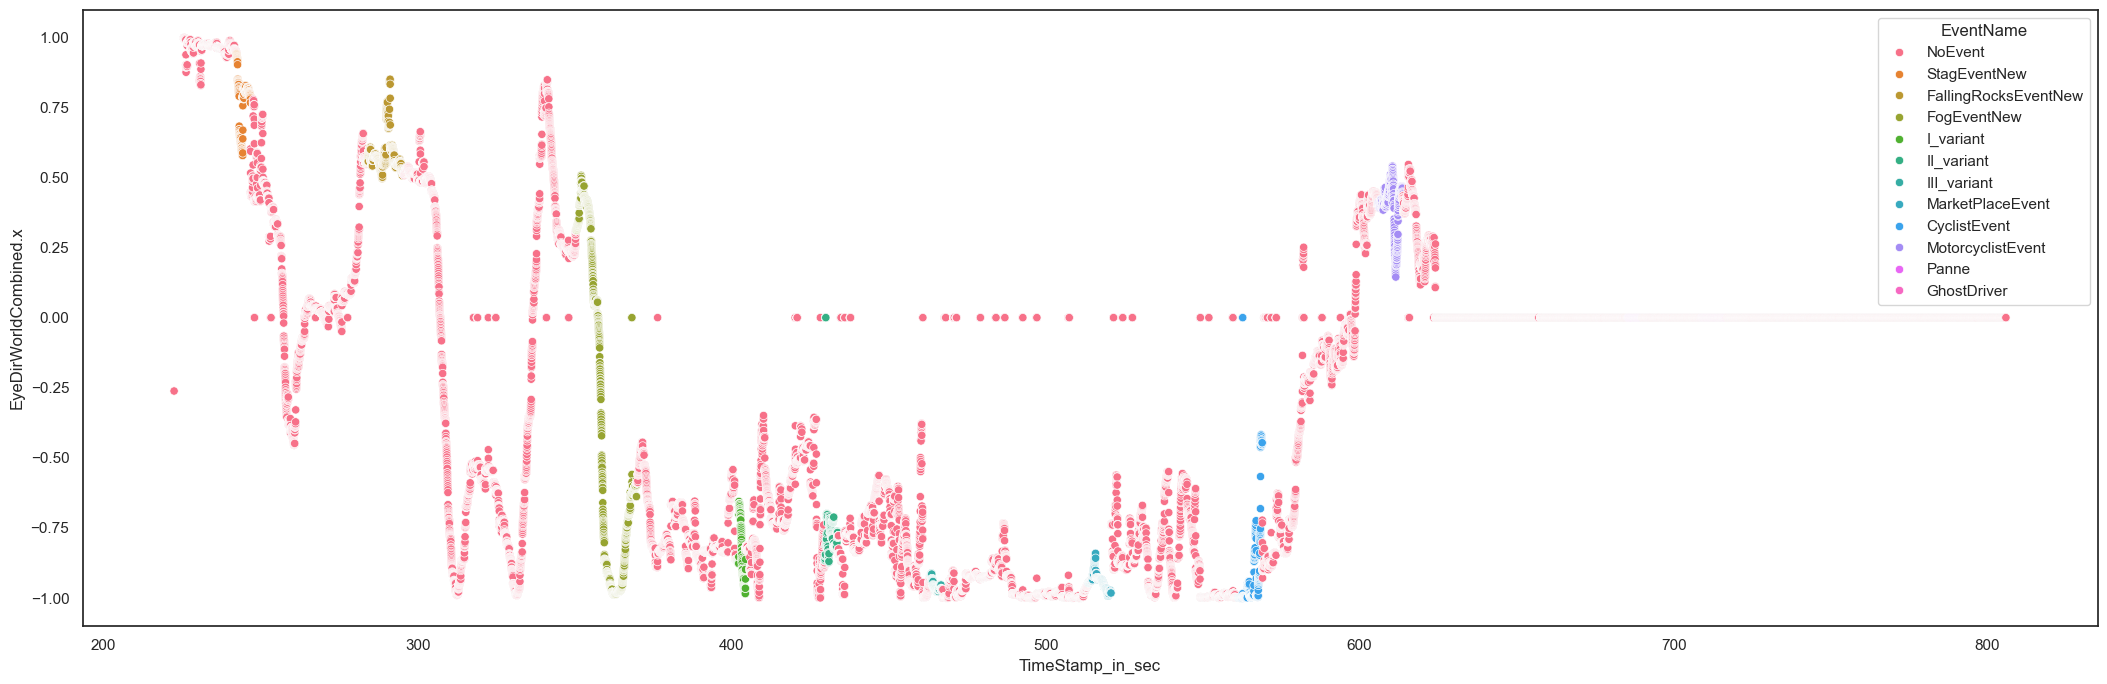

In [25]:
fig, ax = plt.subplots(figsize=(26,8))
sns.scatterplot(x='TimeStamp_in_sec', y='EyeDirWorldCombined.x', 
                data=one_excluded, hue='EventName', legend=True)

In [26]:
# Reject serious eye tracking issues
excluded4s_uid_list = blink_durations_df[blink_durations_df['BlinkDuration'] > 4]['uid'].unique().tolist()
excluded4s_uid_list

['22d6fdd77f704e00aa350bf02adc9bc3',
 '5fe54d902792467181089d8e4a73b80c',
 '7b1f3e040a654bb7afff67a711e46081',
 '81957954cd71450cacc5fd738dd9ebd2',
 'a3bf7bf25cb54d37b0876393df38aa5f',
 'ac50cb2dbe784eca9f86d1a424a3cf04']

In [27]:
# Filter rejected uids with serious recording issues
blinks_under_4s_df = blinks_df[~blinks_df['uid'].isin(excluded4s_uid_list)]
blinks_under_4s_df['uid'].nunique()

160

In [28]:
def visualize_blink_durations(df, save=False, savename=''):
    # Set the visual style
    sns.set(style="white")
    # Create a boxplot for blink durations across participants
    # plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots(2,1, figsize=(26,10))
    sns.stripplot(x='EventName', y='BlinkDuration', data=df, hue ='EventName',
                  legend=True, alpha=0.7, ax=ax[0])
    sns.stripplot(x='uid', y='BlinkDuration', data=df,
                  legend=True, alpha=0.5, ax=ax[1])
    # Add title and labels
    ax[0].set_title('Blink Durations Across Events', fontsize=16)
    ax[1].set_title('Blink Durations per UID', fontsize=16)
    plt.xlabel('', fontsize=14)
    plt.ylabel('Blink Duration (s)', fontsize=14)
    plt.xticks(rotation=80)
    ax[0].axhline(0.205, color='gray', linestyle='--', linewidth=2)
    ax[0].axhline(0.500, color='red', linestyle='--', linewidth=2)
    ax[1].axhline(0.205, color='gray', linestyle='--', linewidth=2)
    ax[1].axhline(0.500, color='red', linestyle='--', linewidth=2)
    # sns.move_legend(ax[1],  "upper left", bbox_to_anchor=(1, 1))
    if save:
        plt.savefig(f"Plots/" + savename +'.jpeg', dpi=500, bbox_inches='tight')
    plt.show()

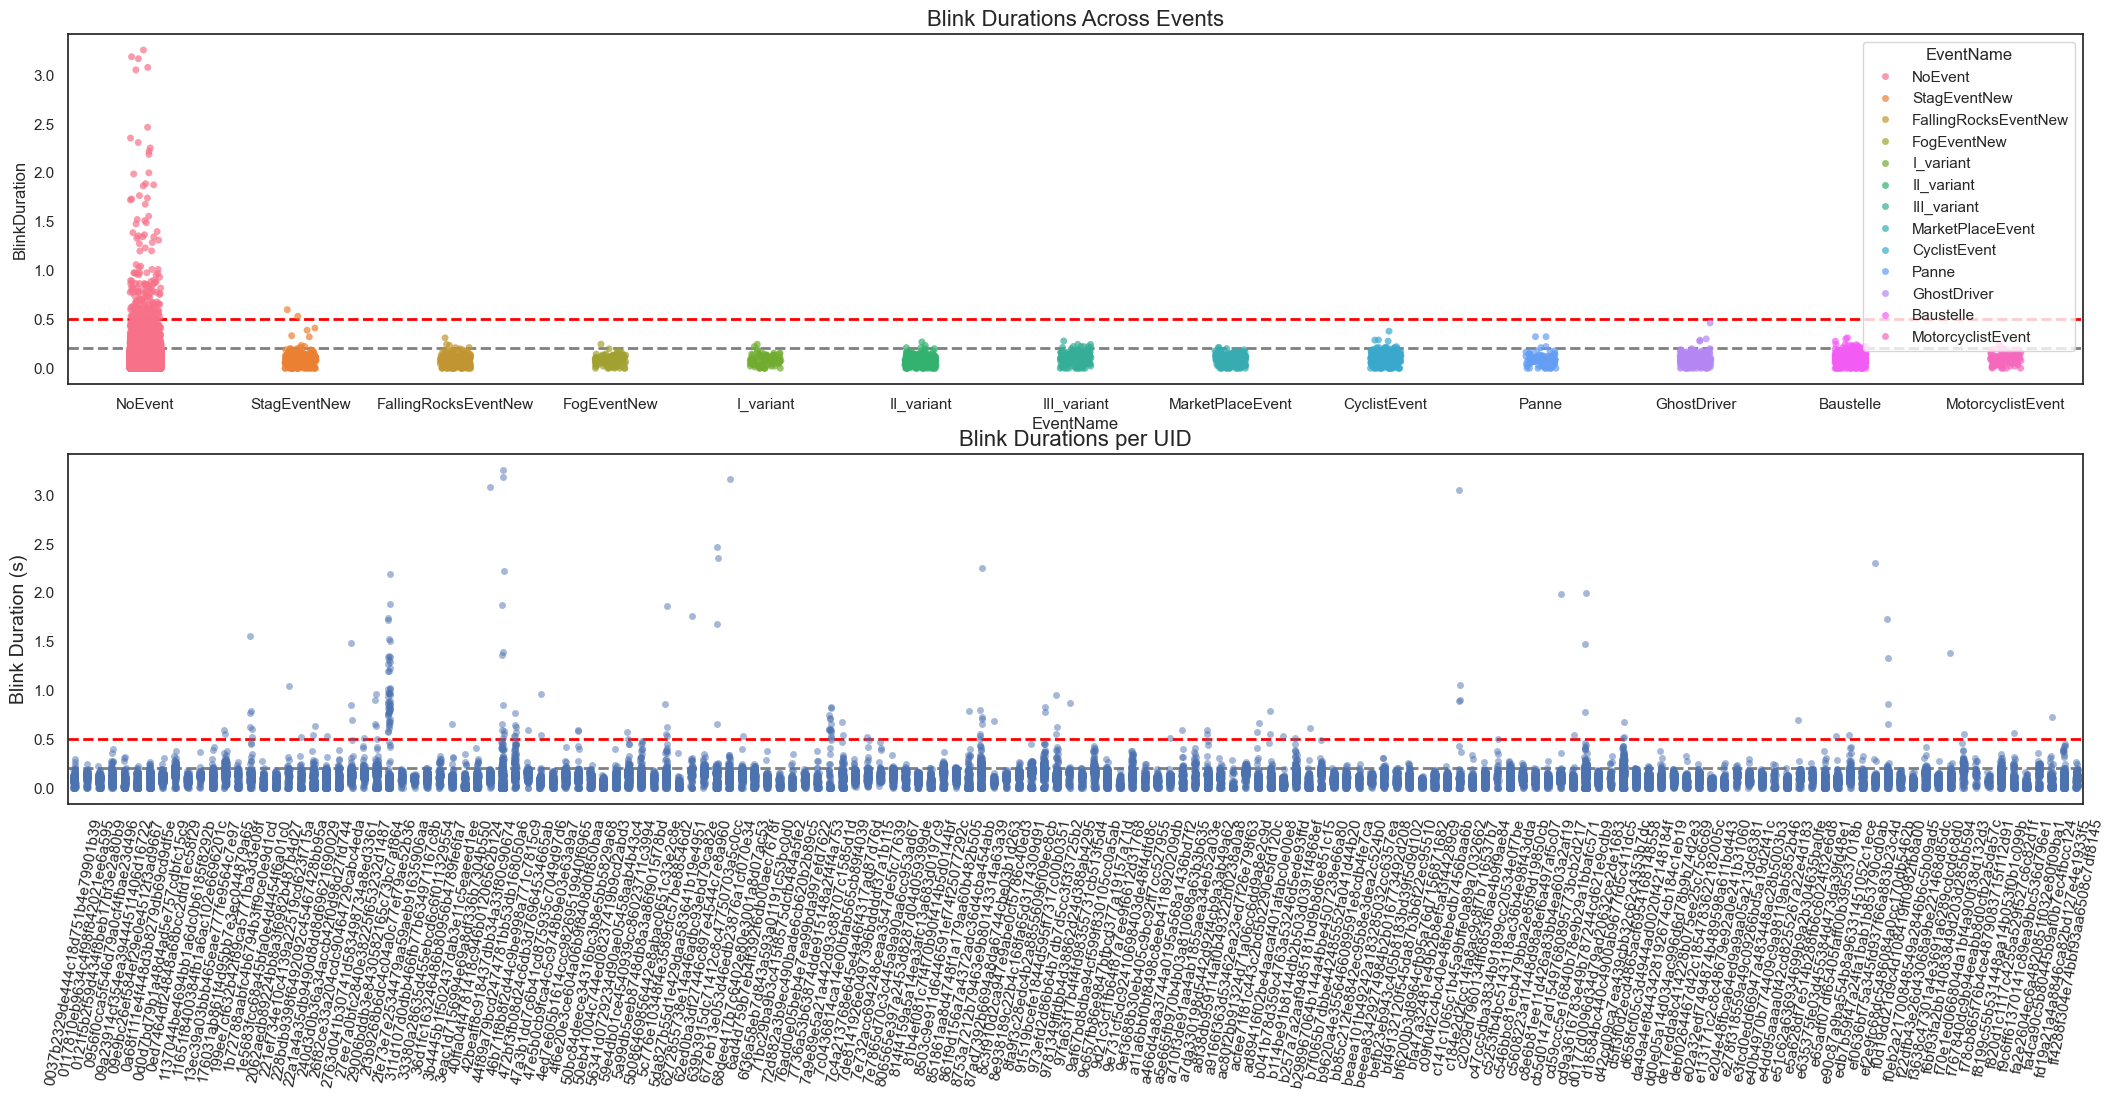

In [29]:
visualize_blink_durations(blinks_under_4s_df, save=False)

Explore remaining blink durations larger than 1s smaller than 4s

In [30]:
# Explore eye tracking issues > 1s < 4s
excluded1s_uid_list = blinks_under_4s_df[blinks_under_4s_df['BlinkDuration'] > 1]#['uid'].unique().tolist()
excluded1s_uid_list

timestamp_REF  \
468054   2020-10-27 13:46:48.492689152+00:00   
559086   2020-09-27 15:07:03.299481088+00:00   
736232   2020-10-16 13:12:19.076011776+00:00   
817197   2020-10-15 12:16:46.373405696+00:00   
817342   2020-10-15 12:16:49.548318720+00:00   
820023   2020-10-15 12:17:41.594035200+00:00   
820467   2020-10-15 12:17:49.126419712+00:00   
822910   2020-10-15 12:18:36.624883968+00:00   
824890   2020-10-15 12:19:15.224897024+00:00   
825393   2020-10-15 12:19:24.066352384+00:00   
827204   2020-10-15 12:19:54.497843456+00:00   
828835   2020-10-15 12:20:21.462852352+00:00   
828954   2020-10-15 12:20:23.651312896+00:00   
832309   2020-10-15 12:21:26.708225024+00:00   
834905   2020-10-15 12:22:13.476925696+00:00   
835051   2020-10-15 12:22:16.107737600+00:00   
835374   2020-10-15 12:22:22.027562496+00:00   
835634   2020-10-15 12:22:26.736531968+00:00   
838005   2020-10-15 12:23:09.494455040+00:00   
838161   2020-10-15 12:23:12.238407680+00:00   
838271   2020-10-15 12:23:14.170099456+00:00   
1067391  2020-10-21 07:55:56.208145152+00:00   
1099051  2020-10-19 08:23:33.406391552+00:00   
1099067  2020-10-19 08:23:36.708099072+00:00   
1099193  2020-10-19 08:23:38.972623104+00:00   
1099730  2020-10-19 08:23:48.447142912+00:00   
1100407  2020-10-19 08:24:00.451963904+00:00   
1102024  2020-10-19 08:24:34.358953984+00:00   
1546164  2020-10-16 13:22:53.820101120+00:00   
1643214  2020-10-20 09:35:56.207256320+00:00   
1696710  2020-09-26 10:44:31.983719936+00:00   
1699155  2020-09-26 10:45:15.807817728+00:00   
1701497  2020-09-26 10:45:57.432543232+00:00   
1711788  2020-09-26 12:20:56.312445696+00:00   
2448095  2020-09-20 11:23:44.872198400+00:00   
3692403  2020-09-20 10:35:49.391036928+00:00   
3713782  2020-09-20 10:42:24.356392448+00:00   
3948938  2020-10-17 11:49:44.477114368+00:00   
4037719  2020-09-26 12:06:20.157860608+00:00   
4038441  2020-09-26 12:06:33.197053952+00:00   
4768561  2020-10-16 14:34:58.858544896+00:00   
4784573  2020-10-20 10:40:50.545692928+00:00   
4803346  2020-10-20 10:46:33.282706688+00:00   
4937829  2020-09-27 13:19:26.912134400+00:00   

                                      uid      dataset  city_section  \
468054   1b72788aabfc4b6794b3ff9ce0e9d1cd  EyeTracking      Autobahn   
559086   221ef734e10c4139a22519cd623f715a  EyeTracking      Autobahn   
736232   2763d041b30741d583498734a8ed3361  EyeTracking    Westbrueck   
817197   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking  MountainRoad   
817342   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking  MountainRoad   
820023   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking  MountainRoad   
820467   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking  MountainRoad   
822910   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking    Westbrueck   
824890   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking    Westbrueck   
825393   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking    Westbrueck   
827204   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking    Westbrueck   
828835   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking    Westbrueck   
828954   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking    Westbrueck   
832309   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking   CountryRoad   
834905   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking   CountryRoad   
835051   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking   CountryRoad   
835374   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking   CountryRoad   
835634   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking   CountryRoad   
838005   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking   CountryRoad   
838161   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking   CountryRoad   
838271   2f3b9268b6dc4c04a0c77ef79ae52b36  EyeTracking   CountryRoad   
1067391  42beaff8c918437dbb34a33f80c90674  EyeTracking  MountainRoad   
1099051  44f89a79bcd2474781bb53db168050a6  EyeTracking  MountainRoad   
1099067  44f89a79bcd2474781bb53db168050a6  EyeTracking  MountainRoad   
1099193  44f89a79bcd2474781bb53db168050a6  EyeTracking  MountainRoad  

In [31]:
# Check one individual uid
blinks_under_4s_df[blinks_under_4s_df['uid'] == '1b72788aabfc4b6794b3ff9ce0e9d1cd']

timestamp_REF                               uid  \
440656  2020-10-27 13:38:21.121392384+00:00  1b72788aabfc4b6794b3ff9ce0e9d1cd   
440657  2020-10-27 13:38:24.138202880+00:00  1b72788aabfc4b6794b3ff9ce0e9d1cd   
440658  2020-10-27 13:38:24.148528128+00:00  1b72788aabfc4b6794b3ff9ce0e9d1cd   
440659  2020-10-27 13:38:24.168697600+00:00  1b72788aabfc4b6794b3ff9ce0e9d1cd   
440660  2020-10-27 13:38:24.189642496+00:00  1b72788aabfc4b6794b3ff9ce0e9d1cd   
...                                     ...                               ...   
472031  2020-10-27 13:47:57.517667072+00:00  1b72788aabfc4b6794b3ff9ce0e9d1cd   
472032  2020-10-27 13:47:57.529635328+00:00  1b72788aabfc4b6794b3ff9ce0e9d1cd   
472033  2020-10-27 13:47:57.542600704+00:00  1b72788aabfc4b6794b3ff9ce0e9d1cd   
472034  2020-10-27 13:47:57.554567936+00:00  1b72788aabfc4b6794b3ff9ce0e9d1cd   
472035  2020-10-27 13:47:57.573517056+00:00  1b72788aabfc4b6794b3ff9ce0e9d1cd   

            dataset  city_section ExperimentalCondition  UnixTimeStamp  \
440656  EyeTracking  MountainRoad               HUDOnly   1.603806e+09   
440657  EyeTracking  MountainRoad               HUDOnly   1.603806e+09   
440658  EyeTracking  MountainRoad               HUDOnly   1.603806e+09   
440659  EyeTracking  MountainRoad               HUDOnly   1.603806e+09   
440660  EyeTracking  MountainRoad               HUDOnly   1.603806e+09   
...             ...           ...                   ...            ...   
472031  EyeTracking      Autobahn               HUDOnly   1.603806e+09   
472032  EyeTracking      Autobahn               HUDOnly   1.603806e+09   
472033  EyeTracking      Autobahn               HUDOnly   1.603806e+09   
472034  EyeTracking      Autobahn               HUDOnly   1.603806e+09   
472035  EyeTracking      Autobahn               HUDOnly   1.603806e+09   

        TobiiTimeStamp        FPS  RightEyeIsBlinkingWorld  \
440656     1301.719116  90.090492                    False   
440657        0.000000   3.215793                    False   
440658        0.000000   3.554939                    False   
440659        0.000000   3.919797                    False   
440660        0.000000   4.791452                    False   
...                ...        ...                      ...   
472031     1890.966064  88.119270                    False   
472032     1890.977417  88.169266                    False   
472033     1890.990479  86.832703                    False   
472034     1891.003296  85.835960                    False   
472035     1891.021362  81.409843                    False   

        RightEyeIsBlinkingLocal  ...     TimeStamp  ReceivedInput  \
440656                    False  ...  1.603806e+09           True   
440657                    False  ...  1.603806e+09           True   
440658                    False  ...  1.603806e+09           True   
440659                    False  ...  1.603806e+09           True   
440660                    False  ...  1.603806e+09           True   
...                         ...  ...           ...            ...   
472031                    False  ...  1.603806e+09           True   
472032                    False  ...  1.603806e+09           True   
472033                    False  ...  1.603806e+09           True   
472034                    False  ...  1.603806e+09           True   
472035                    False  ...  1.603806e+09           True   

        SteeringInput  AcellerationInput  BrakeInput  TimeStamp_in_sec  \
440656      -0.074072                0.0         0.0        157.059637   
440657      -0.010592                0.0         0.0        160.076447   
440658      -0.010592                0.0         0.0        160.086773   
440659      -0.010592                0.0         0.0        160.106942   
440660      -0.010592                0.0         0.0        160.127887   
...               ...                ...         ...               ...   
472031      -0.010134                0.0         0.0        733.455912   
47

### 2.4 Blinks interpolation
After excluding uids with serious eye tracking issues (i.e., blinks > 4s), we saved the data in a `excluded4s_df` we interpolate all blink durations smaller than or equal to 0.5 s (i.e., 500ms)

In [32]:
pd.options.mode.copy_on_write = True
def interpolate_eye_blinks_uid(df, blink_duration=0.5):
    # 1. Create a mask for long blinks longer than 0.5 seconds
    max_blink_mask = (df['BlinkDurationsLong'] <= blink_duration) & (df['Blink'] == True)
    # 2. Specify eye columns
    eye_columns  = ['EyeDirLocalCombined.x', 'EyeDirLocalCombined.y',
                    'EyeDirLocalCombined.z', 'EyePosLocalCombined.x',
                    'EyePosLocalCombined.y', 'EyePosLocalCombined.z',
                    'EyeDirWorldCombined.x', 'EyeDirWorldCombined.y',
                    'EyeDirWorldCombined.z', 'EyePosWorldCombined.x',
                    'EyePosWorldCombined.y', 'EyePosWorldCombined.z'
                    ]
    # 3. Convert all eye values to NaN where max_blink_mask is True
    df.loc[max_blink_mask, eye_columns] = np.nan
    
    # 4. Group by 'uid' and create interpolated DataFrame only for specified columns
    def interpolate_group(group):
        # Interpolate only specified eye columns
        group[eye_columns] = group[eye_columns].interpolate(method='linear', limit_direction='both')
        return group

    # Apply the interpolation function to each group and retain the original structure
    interpolated_df = df.groupby('uid').apply(interpolate_group).reset_index(drop=True)

    # Group by 'uid' and interpolate NaN values
    # interpolated_df = df.groupby('uid').apply(lambda group: group.infer_objects(copy=False).interpolate(method='linear').ffill().bfill()).reset_index(drop=True)
    return interpolated_df

In [33]:
# sample_df = blinks_under_4s_df[blinks_under_4s_df['uid']=='0037b2329de444c18d751b4e79901b39']

In [34]:
# Apply interpolation function on dataset after ex
interpolated_df = interpolate_eye_blinks_uid(blinks_under_4s_df)

C:\Users\erene\AppData\Local\Temp\ipykernel_15516\1080496271.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interpolated_df = df.groupby('uid').apply(interpolate_group).reset_index(drop=True)


In [35]:
interpolated_df

timestamp_REF  \
0        2020-09-26 13:46:07.387864320+00:00   
1        2020-09-26 13:46:10.404847616+00:00   
2        2020-09-26 13:46:10.415003904+00:00   
3        2020-09-26 13:46:10.432984064+00:00   
4        2020-09-26 13:46:10.444952320+00:00   
...                                      ...   
5098682  2020-09-19 10:31:35.095044608+00:00   
5098683  2020-09-19 10:31:35.116986112+00:00   
5098684  2020-09-19 10:31:35.139722752+00:00   
5098685  2020-09-19 10:31:35.150694400+00:00   
5098686  2020-09-19 10:31:35.172635904+00:00   

                                      uid      dataset  city_section  \
0        0037b2329de444c18d751b4e79901b39  EyeTracking  MountainRoad   
1        0037b2329de444c18d751b4e79901b39  EyeTracking  MountainRoad   
2        0037b2329de444c18d751b4e79901b39  EyeTracking  MountainRoad   
3        0037b2329de444c18d751b4e79901b39  EyeTracking  MountainRoad   
4        0037b2329de444c18d751b4e79901b39  EyeTracking  MountainRoad   
...                                   ...          ...           ...   
5098682  ff4288f304e74bbf93aa6508c7df8145  EyeTracking      Autobahn   
5098683  ff4288f304e74bbf93aa6508c7df8145  EyeTracking      Autobahn   
5098684  ff4288f304e74bbf93aa6508c7df8145  EyeTracking      Autobahn   
5098685  ff4288f304e74bbf93aa6508c7df8145  EyeTracking      Autobahn   
5098686  ff4288f304e74bbf93aa6508c7df8145  EyeTracking      Autobahn   

        ExperimentalCondition  UnixTimeStamp  TobiiTimeStamp        FPS  \
0               BaseCondition   1.601128e+09      320.263977  90.002266   
1               BaseCondition   1.601128e+09      336.057007   3.215231   
2               BaseCondition   1.601128e+09      336.071259   3.554384   
3               BaseCondition   1.601128e+09      336.089417   3.921189   
4               BaseCondition   1.601128e+09      336.101135   4.334725   
...                       ...            ...             ...        ...   
5098682            FullLoopAR   1.600511e+09     1277.914185  90.083817   
5098683            FullLoopAR   1.600511e+09     1277.936523  89.880363   
5098684            FullLoopAR   1.600511e+09     1277.958374  90.203796   
5098685            FullLoopAR   1.600511e+09     1277.969727  89.948059   
5098686            FullLoopAR   1.600511e+09     1277.991943  89.988075   

         RightEyeIsBlinkingWorld  RightEyeIsBlinkingLocal  ...     TimeStamp  \
0                          False                    False  ...  1.601128e+09   
1                          False                    False  ...  1.601128e+09   
2                          False                    False  ...  1.601128e+09   
3                          False                    False  ...  1.601128e+09   
4                          False                    False  ...  1.601128e+09   
...                          ...                      ...  ...           ...   
5098682                    False                    False  ...  1.600511e+09   
5098683                    False                    False  ...  1.600511e+09   
5098684                    False                    False  ...  1.600511e+09   
5098685                    False                    False  ...  1.600511e+09   
5098686                    False                    False  ...  1.600511e+09   

         ReceivedInput  SteeringInput  AcellerationInput  BrakeInput  \
0                 True      -0.063991                0.0         0.0   
1                 True      -0.012914                0.0         0.0   
2                 True      -0.012914                0.0         0.0   
3                 True      -0.012914                0.0         0.0   
4                 True      -0.012914                0.0         0.0   
...                ...            ...                ...         ...   
5098682           True      -0.007354                0.0         0.0   
5098683           True      -0.007354                0.0         0.0   
5098684           True      -0.007354                0.0         0.0   
5098685

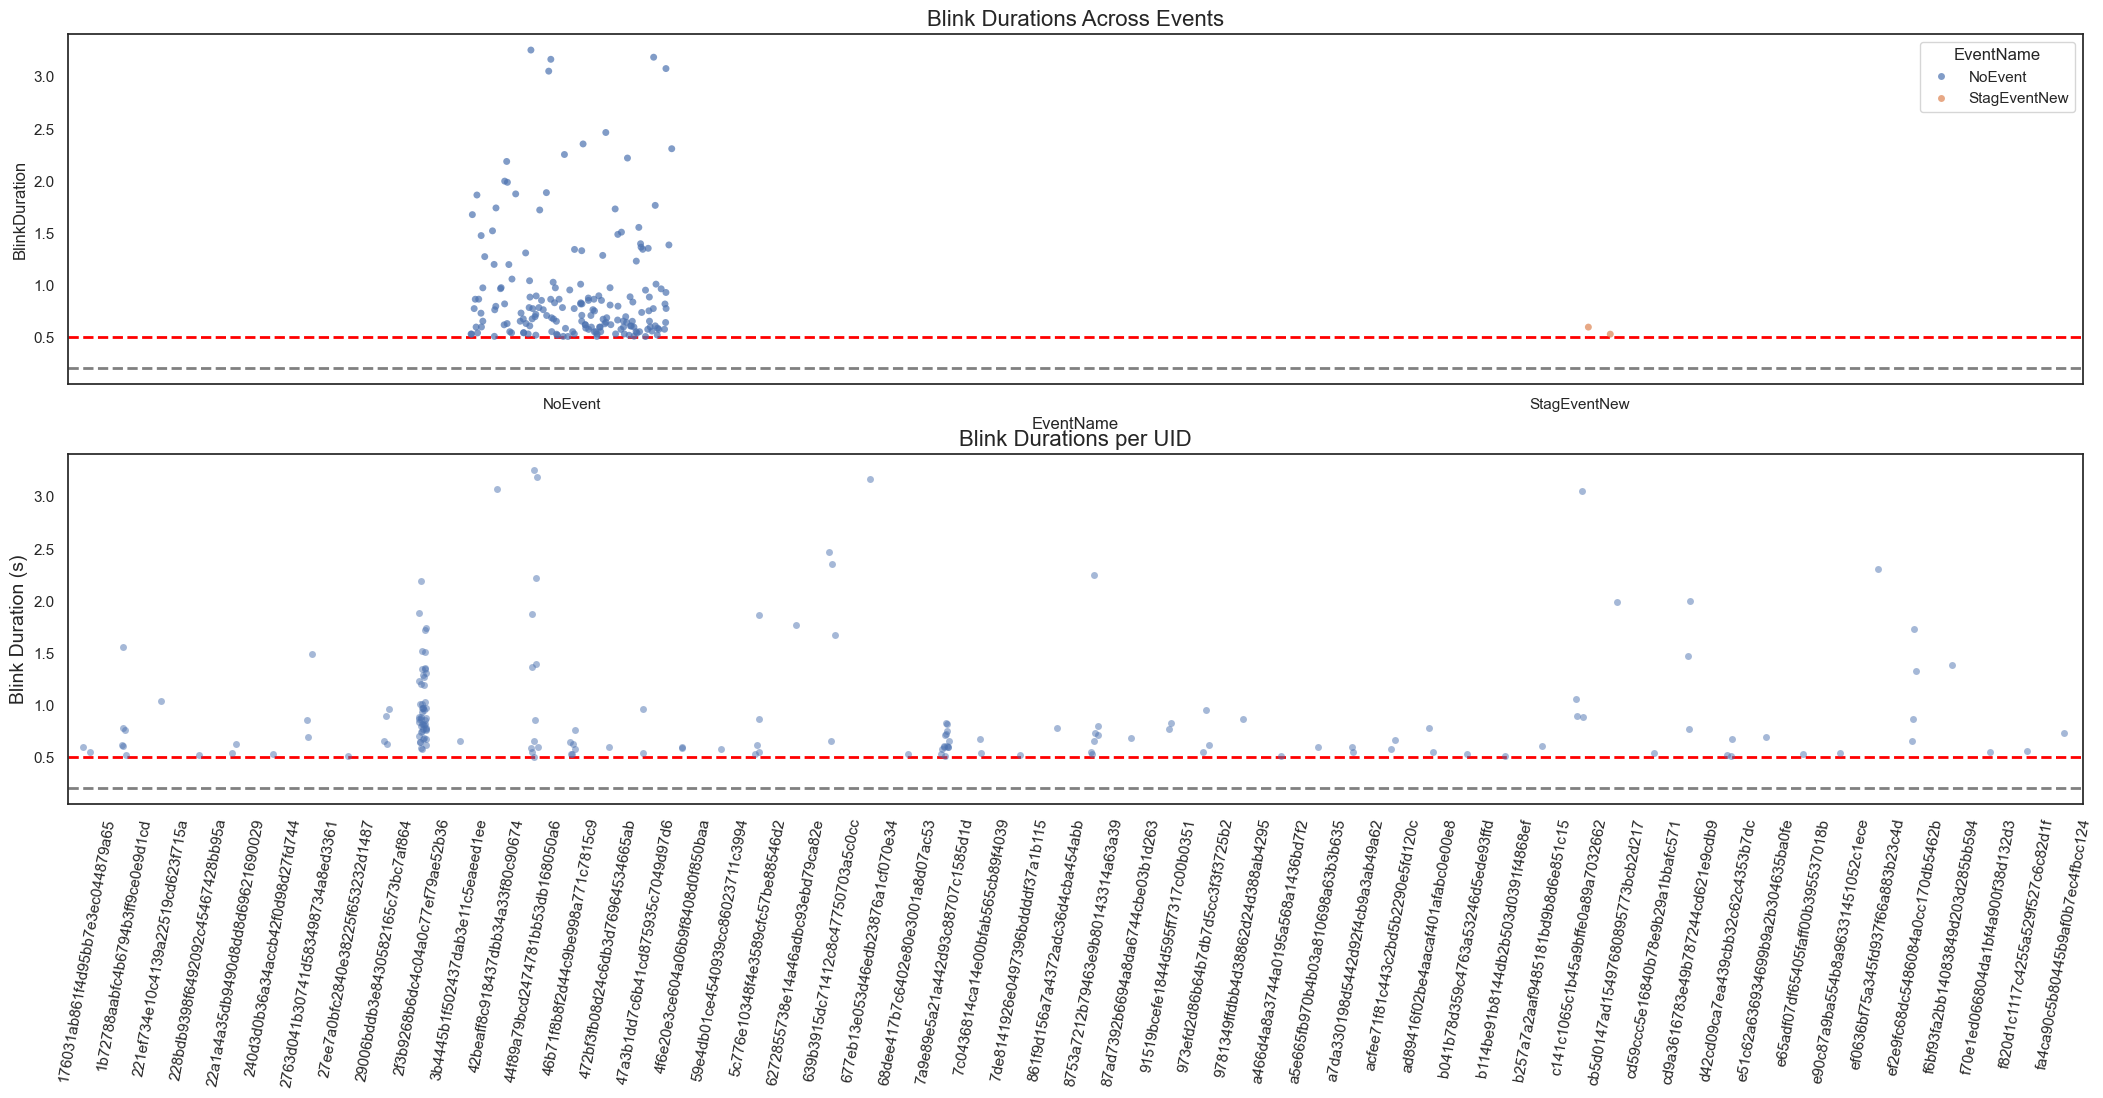

In [36]:
visualize_blink_durations(interpolated_df[interpolated_df['BlinkDuration']>0.5], save=True, savename='blink_durations_after_interpolation')

Visualizing one uid with several long blinks/eye closed 

In [37]:
uid_many_long_blinks = interpolated_df[interpolated_df['uid'].str.startswith('2f3b92')]

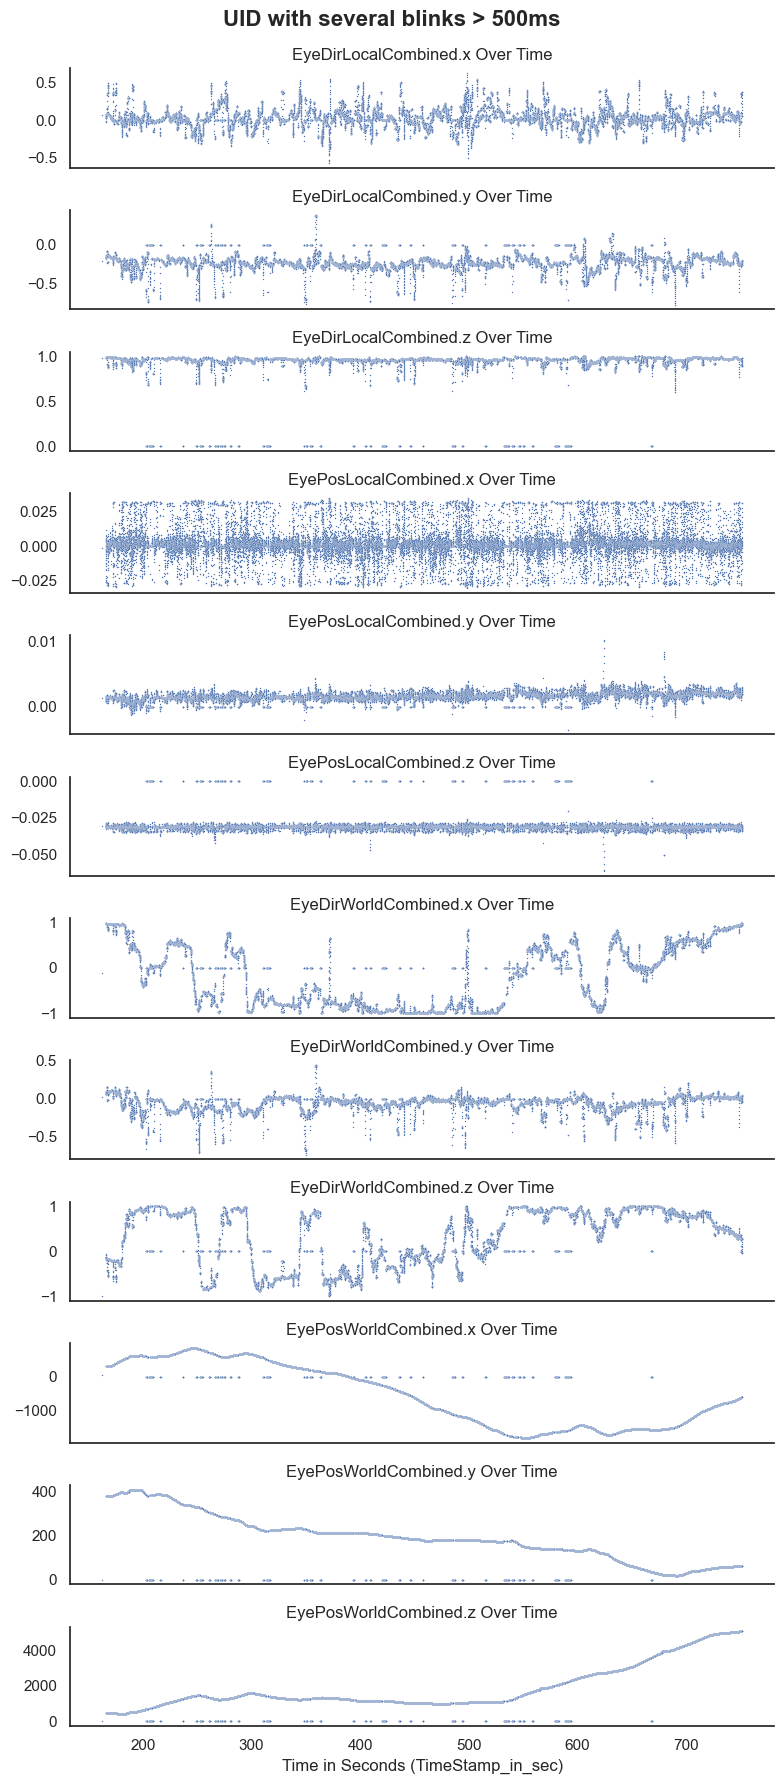

In [38]:
# Create subplots for each eye column
eye_columns  = ['EyeDirLocalCombined.x', 'EyeDirLocalCombined.y',
                    'EyeDirLocalCombined.z', 'EyePosLocalCombined.x',
                    'EyePosLocalCombined.y', 'EyePosLocalCombined.z',
                    'EyeDirWorldCombined.x', 'EyeDirWorldCombined.y',
                    'EyeDirWorldCombined.z', 'EyePosWorldCombined.x',
                    'EyePosWorldCombined.y', 'EyePosWorldCombined.z'
                    ]
num_columns = len(eye_columns)
fig, axes = plt.subplots(num_columns, 1, figsize=(8, 1.5 *num_columns), sharex=True)
fig.suptitle('UID with several blinks > 500ms', fontsize=16,y=0.99,fontweight='bold')

for ax, eye_column in zip(axes, eye_columns):
    sns.scatterplot(x='TimeStamp_in_sec', y=
               eye_column, data=uid_many_long_blinks,marker='o', s=1,
               linestyle='-', legend=False, ax=ax)
    ax.set_title(f'{eye_column} Over Time')
    ax.set_ylabel('')
    # ax.legend()
sns.despine()
# Set x-axis label
plt.xlabel('Time in Seconds (TimeStamp_in_sec)')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## 4. Steering Wheel 
Make sure there are not recording issues. 

In [39]:
# TODO: calculate steering wheel missing input durations

## 5. Removing duplicate rows

In [40]:
# Store the original number of rows
original_row_count = len(interpolated_df)

# Remove consecutive duplicates, keep only the first occurrence
interpolated_df = interpolated_df.drop_duplicates(keep='first')

# Calculate the number of rows after removing duplicates
new_row_count = len(interpolated_df)

# Calculate and store the number of deleted rows
deleted_rows = original_row_count - new_row_count

# Print the number of deleted rows
print(f"Number of deleted rows: {deleted_rows}")

Number of deleted rows: 0


In [41]:
# Assuming 'interpolated_df' is your DataFrame
# Filter the DataFrame to get rows where the 'uid' column matches the specific UID
filtered_rows = interpolated_df[interpolated_df['uid'] == '4a10fec1583843e5b1c82fb74fa7c775']

# Print the filtered rows
print(filtered_rows)

Empty DataFrame
Columns: [timestamp_REF, uid, dataset, city_section, ExperimentalCondition, UnixTimeStamp, TobiiTimeStamp, FPS, RightEyeIsBlinkingWorld, RightEyeIsBlinkingLocal, LeftEyeIsBlinkingWorld, LeftEyeIsBlinkingLocal, HmdPosition.x, HmdPosition.y, HmdPosition.z, NoseVector.x, NoseVector.y, NoseVector.z, EyePosWorldCombined.x, EyePosWorldCombined.y, EyePosWorldCombined.z, EyeDirWorldCombined.x, EyeDirWorldCombined.y, EyeDirWorldCombined.z, EyePosLocalCombined.x, EyePosLocalCombined.y, EyePosLocalCombined.z, EyeDirLocalCombined.x, EyeDirLocalCombined.y, EyeDirLocalCombined.z, ObjectName_1, ObjectName_2, ObjectName_3, ObjectName_4, ObjectName_5, HitObjectPosition.x_1, HitObjectPosition.x_2, HitObjectPosition.x_3, HitObjectPosition.x_4, HitObjectPosition.x_5, HitObjectPosition.y_1, HitObjectPosition.y_2, HitObjectPosition.y_3, HitObjectPosition.y_4, HitObjectPosition.y_5, HitObjectPosition.z_1, HitObjectPosition.z_2, HitObjectPosition.z_3, HitObjectPosition.z_4, HitObjectPosition.z

## 6. Resampling to 50Hz
Resample the data to 50Hz 

In [ ]:
""" # Ensure 'UnixTimeStamp' is treated correctly (assuming it's in seconds since epoch)
interpolated_df['UnixTimeStamp'] = pd.to_datetime(interpolated_df['UnixTimeStamp'], unit='s')

# Set 'UnixTimeStamp' as the DataFrame's index
interpolated_df.set_index('UnixTimeStamp', inplace=True)

# Function to apply specific resampling rules based on data type
def resample_data(group):
    # Resample to 20ms intervals
    resampled = group.resample('20ms').first()  # Use .first() to avoid automatic mean for numeric types

    # Interpolate numeric columns
    numeric_cols = group.select_dtypes(include=[np.number]).columns
    resampled[numeric_cols] = resampled[numeric_cols].interpolate()

    # Forward fill for non-numeric columns
    non_numeric_cols = group.select_dtypes(exclude=[np.number]).columns
    resampled[non_numeric_cols] = resampled[non_numeric_cols].ffill()

    return resampled

# Apply the resampling function per unique 'uid'
result = pd.DataFrame()  # Initialize an empty DataFrame to hold results
uids = interpolated_df['uid'].dropna().unique()  # Assuming 'uid' is the identifier column

for uid in uids:
    uid_group = interpolated_df[interpolated_df['uid'] == uid]
    resampled_group = resample_data(uid_group)
    result = pd.concat([result, resampled_group])

# Reset the index if you want 'UnixTimeStamp' back as a regular column
result.reset_index(inplace=True)

resampled_interpolated_df = result

resampled_interpolated_df """

In [ ]:
# --- Ensure 'timestamp_REF' is the Index Without Dropping It ---
interpolated_df.set_index('timestamp_REF', inplace=True, drop=False)

# --- Define the Resampling Function ---
def resample_data(group):
    """Resample participant's data at 50Hz (20ms) with mean for numeric & first for categorical."""
    
    # Ensure the index is a DatetimeIndex
    group.index = pd.to_datetime(group.index)
    
    # Separate numeric and non-numeric columns
    numeric_cols = group.select_dtypes(include=[np.number]).columns
    non_numeric_cols = group.select_dtypes(exclude=[np.number]).columns
    
    # Resample numeric columns using mean()
    resampled_numeric = group[numeric_cols].resample('20ms').mean()
    
    # Resample non-numeric columns using first()
    resampled_non_numeric = group[non_numeric_cols].resample('20ms').first()
    
    # Merge numeric and non-numeric resampled data
    resampled = pd.concat([resampled_numeric, resampled_non_numeric], axis=1)
    
    # Interpolate missing values in numeric columns
    resampled[numeric_cols] = resampled[numeric_cols].interpolate()
    
    # Forward-fill non-numeric columns
    resampled[non_numeric_cols] = resampled[non_numeric_cols].ffill()
    
    return resampled

# --- Resample Per Participant ---
resampled_interpolated_df = pd.DataFrame()
uids = interpolated_df['uid'].dropna().unique()

for uid in uids:
    print(f"Processing UID {uid}...")  # Debug Progress
    
    # Filter for this participant
    uid_group = interpolated_df[interpolated_df['uid'] == uid]
    
    # Skip if there's no data
    if uid_group.empty:
        continue
    
    # Resample
    resampled_group = resample_data(uid_group)
    
    # Drop 'timestamp_REF' **before** resetting index to avoid duplication error
    if 'timestamp_REF' in resampled_group.columns:
        resampled_group.drop(columns=['timestamp_REF'], inplace=True)
    
    # Reset Index (Keep 'timestamp_REF' as a Column)
    resampled_group.reset_index(inplace=True)
    
    # Leave UnixTimeStamp and TobiiTimeStamp Empty
    resampled_group['UnixTimeStamp'] = np.nan
    resampled_group['TobiiTimeStamp'] = np.nan
    
    # Append to final DataFrame
    resampled_interpolated_df = pd.concat([resampled_interpolated_df, resampled_group])

""" # --- Save First 10,000 Rows to CSV ---
resampled_interpolated_df.head(10000).to_csv("resampled_first_10000_rows.csv", index=False) """

print("\n✅ Resampling Complete!")


Processing UID 0037b2329de444c18d751b4e79901b39...
Processing UID 0117810eb9634c4f98f842021ee6a595...
Processing UID 0121f5b2f59d434f8beb17bf3e2a80b9...
Processing UID 0956f0cca5f546d79a0cf4fbae23d496...
Processing UID 09a23914cf354ea39444511406d16722...
Processing UID 09e9bc26ef584ef29e0e4512f3ad9667...
Processing UID 0a68f111e4f448d3b8279db69cd9df5e...
Processing UID 0d0d7bd79b1a48d4ad5e757cdbfc15c9...
Processing UID 0ed7464df24848a68bcc2dfd1ec58f29...
Processing UID 1137044be4694bb1a6dc0b6185f8292b...
Processing UID 11651f8400384fb1a6ac102e6696201c...
Processing UID 13ec39a03bbb465eae777fe9564c7e97...
Processing UID 176031ab861f4d95bb7e3ec044879a65...
Processing UID 199ee7cf632b42f89ca5771ba3d3e08f...
Processing UID 1b72788aabfc4b6794b3ff9ce0e9d1cd...
Processing UID 1e5683fcc68a45bfa0e4d4454f6a01c0...
Processing UID 2062aedb89224bb8a3f6982b487b4d27...
Processing UID 221ef734e10c4139a22519cd623f715a...
Processing UID 228bdb9398f6492092c45467428bb95a...
Processing UID 22a1a4a35db9490d

In [47]:
# Initialize a new column for sampling rate
resampled_interpolated_df['SamplingRate'] = np.nan

# Calculate the sampling rate for each participant
for uid in resampled_interpolated_df['uid'].unique():
    uid_df = resampled_interpolated_df[resampled_interpolated_df['uid'] == uid]
    
    # Calculate time differences between consecutive timestamps
    time_diffs = uid_df['timestamp_REF'].diff().dt.total_seconds()  # Ensure timestamps are in seconds
    uid_df['SamplingRate'] = 1 / time_diffs  # Calculate sampling rate (samples per second)
    
    # Update the main DataFrame
    resampled_interpolated_df.loc[resampled_interpolated_df['uid'] == uid, 'SamplingRate'] = uid_df['SamplingRate']

# Drop NaN values for sampling rate, which occur at the first index of each UID
resampled_interpolated_df = resampled_interpolated_df.dropna(subset=['SamplingRate'])

In [48]:
resampled_interpolated_df

timestamp_REF  UnixTimeStamp  TobiiTimeStamp  \
1     2020-09-26 13:46:07.400000+00:00            NaN             NaN   
2     2020-09-26 13:46:07.420000+00:00            NaN             NaN   
3     2020-09-26 13:46:07.440000+00:00            NaN             NaN   
4     2020-09-26 13:46:07.460000+00:00            NaN             NaN   
5     2020-09-26 13:46:07.480000+00:00            NaN             NaN   
...                                ...            ...             ...   
29240 2020-09-19 10:31:35.080000+00:00            NaN             NaN   
29241 2020-09-19 10:31:35.100000+00:00            NaN             NaN   
29242 2020-09-19 10:31:35.120000+00:00            NaN             NaN   
29243 2020-09-19 10:31:35.140000+00:00            NaN             NaN   
29244 2020-09-19 10:31:35.160000+00:00            NaN             NaN   

             FPS  HmdPosition.x  HmdPosition.y  HmdPosition.z  NoseVector.x  \
1      89.428640     311.687001     377.338481     465.514678      0.852939   
2      88.855015     311.686991     377.338492     465.514830      0.853401   
3      88.281389     311.686980     377.338502     465.514982      0.853862   
4      87.707764     311.686970     377.338513     465.515134      0.854323   
5      87.134138     311.686960     377.338524     465.515286      0.854784   
...          ...            ...            ...            ...           ...   
29240  90.083817    -604.575928      64.076195    5073.494141      0.929097   
29241  89.880363    -604.216919      64.088516    5073.639160      0.929055   
29242  90.203796    -603.859375      64.100693    5073.782227      0.929114   
29243  89.948059    -603.504578      64.112839    5073.925781      0.929149   
29244  89.988075    -603.151367      64.124939    5074.067871      0.929320   

       NoseVector.y  NoseVector.z  ...  ObjectName_1      ObjectName_2  \
1          0.098728     -0.511583  ...          <NA>              <NA>   
2          0.098790     -0.509799  ...          <NA>              <NA>   
3          0.098851     -0.508015  ...          <NA>              <NA>   
4          0.098912     -0.506230  ...          <NA>              <NA>   
5          0.098973     -0.504446  ...          <NA>              <NA>   
...             ...           ...  ...           ...               ...   
29240     -0.013814      0.369579  ...       CarBody  Autobahn_Terrain   
29241     -0.013392      0.369700  ...       CarBody  Autobahn_Terrain   
29242     -0.012979      0.369567  ...       CarBody  Autobahn_Terrain   
29243     -0.012842      0.369482  ...       CarBody  Autobahn_Terrain   
29244     -0.012407      0.369067  ...       CarBody  Autobahn_Terrain   

           ObjectName_3      ObjectName_4      ObjectName_5  EventName  \
1                  <NA>              <NA>              <NA>    NoEvent   
2                  <NA>              <NA>              <NA>    NoEvent   
3                  <NA>              <NA>              <NA>    NoEvent   
4                  <NA>              <NA>              <NA>    NoEvent   
5                  <NA>              <NA>              <NA>    NoEvent   
...                 ...               ...               ...        ...   
29240  Default Road 001  Default Road 001  Default Road 001    NoEvent   
29241  Default Road 001  Default Road 001  Default Road 001    NoEvent   
29242  Default Road 001  Default Road 001  Default Road 001    NoEvent   
29243  Default Road 001  Default Road 001  Default Road 001    NoEvent   
29244  Default Road 001  Default Road 001  Default Road 001    NoEvent   

       HitObjectName  ReceivedInput  Blink  SamplingRate  
1               <NA>            1.0    0.0          50.0  
2               <NA>            1.0    0.0          50.0  
3               <NA>            1.0    0.0          50.0  
4               <NA>            1.0    0.0          50.0  
5               <NA>            1.0    0.0          50.0  
...              ...            ...    ...           ...  
29240   

C:\Users\erene\AppData\Local\Temp\ipykernel_15516\3814864414.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Participant')


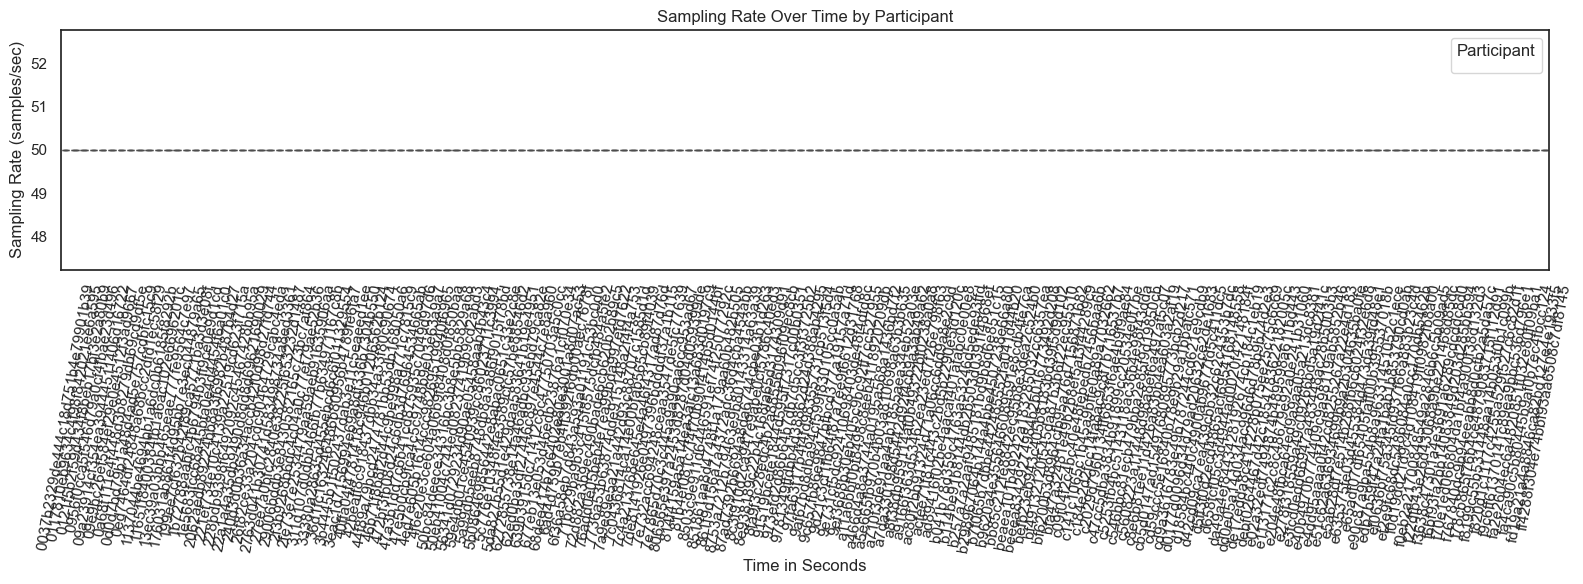

In [55]:
# Visualization
plt.figure(figsize=(16, 6))
# for uid in resampled_interpolated_df['uid'].unique():
#     participant_data = resampled_interpolated_df[resampled_interpolated_df['uid'] == resampled_interpolated_df]
#     # Plot with a line plot
#     plt.plot(participant_data['TimeStamp_in_sec'], 
#              participant_data['SamplingRate'], 
#              marker='o', linestyle='-', label=uid)
sns.boxplot(x='uid', y='SamplingRate', data=resampled_interpolated_df)
plt.title('Sampling Rate Over Time by Participant')
plt.xlabel('Time in Seconds')
plt.ylabel('Sampling Rate (samples/sec)')
plt.legend(title='Participant')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()


In [50]:
# Display the DataFrame in a table format
b = interpolated_df[interpolated_df['uid']=='6f36a58eb7d843a593a01191c53bc0d0']
display(b)

timestamp_REF  \
timestamp_REF                                                              
2020-10-21 12:18:47.819205632+00:00  2020-10-21 12:18:47.819205632+00:00   
2020-10-21 12:18:50.850539264+00:00  2020-10-21 12:18:50.850539264+00:00   
2020-10-21 12:18:50.866237696+00:00  2020-10-21 12:18:50.866237696+00:00   
2020-10-21 12:18:50.875747328+00:00  2020-10-21 12:18:50.875747328+00:00   
2020-10-21 12:18:50.888701184+00:00  2020-10-21 12:18:50.888701184+00:00   
...                                                                  ...   
2020-10-21 12:28:39.019028992+00:00  2020-10-21 12:28:39.019028992+00:00   
2020-10-21 12:28:39.039972864+00:00  2020-10-21 12:28:39.039972864+00:00   
2020-10-21 12:28:39.062911488+00:00  2020-10-21 12:28:39.062911488+00:00   
2020-10-21 12:28:39.084851456+00:00  2020-10-21 12:28:39.084851456+00:00   
2020-10-21 12:28:39.106794240+00:00  2020-10-21 12:28:39.106794240+00:00   

                                                                  uid  \
timestamp_REF                                                           
2020-10-21 12:18:47.819205632+00:00  6f36a58eb7d843a593a01191c53bc0d0   
2020-10-21 12:18:50.850539264+00:00  6f36a58eb7d843a593a01191c53bc0d0   
2020-10-21 12:18:50.866237696+00:00  6f36a58eb7d843a593a01191c53bc0d0   
2020-10-21 12:18:50.875747328+00:00  6f36a58eb7d843a593a01191c53bc0d0   
2020-10-21 12:18:50.888701184+00:00  6f36a58eb7d843a593a01191c53bc0d0   
...                                                               ...   
2020-10-21 12:28:39.019028992+00:00  6f36a58eb7d843a593a01191c53bc0d0   
2020-10-21 12:28:39.039972864+00:00  6f36a58eb7d843a593a01191c53bc0d0   
2020-10-21 12:28:39.062911488+00:00  6f36a58eb7d843a593a01191c53bc0d0   
2020-10-21 12:28:39.084851456+00:00  6f36a58eb7d843a593a01191c53bc0d0   
2020-10-21 12:28:39.106794240+00:00  6f36a58eb7d843a593a01191c53bc0d0   

                                         dataset  city_section  \
timestamp_REF                                                    
2020-10-21 12:18:47.819205632+00:00  EyeTracking  MountainRoad   
2020-10-21 12:18:50.850539264+00:00  EyeTracking  MountainRoad   
2020-10-21 12:18:50.866237696+00:00  EyeTracking  MountainRoad   
2020-10-21 12:18:50.875747328+00:00  EyeTracking  MountainRoad   
2020-10-21 12:18:50.888701184+00:00  EyeTracking  MountainRoad   
...                                          ...           ...   
2020-10-21 12:28:39.019028992+00:00  EyeTracking      Autobahn   
2020-10-21 12:28:39.039972864+00:00  EyeTracking      Autobahn   
2020-10-21 12:28:39.062911488+00:00  EyeTracking      Autobahn   
2020-10-21 12:28:39.084851456+00:00  EyeTracking      Autobahn   
2020-10-21 12:28:39.106794240+00:00  EyeTracking      Autobahn   

                                    ExperimentalCondition  UnixTimeStamp  \
timestamp_REF                                                              
2020-10-21 12:18:47.819205632+00:00               HUDOnly   1.603283e+09   
2020-10-21 12:18:50.850539264+00:00               HUDOnly   1.603283e+09   
2020-10-21 12:18:50.866237696+00:00               HUDOnly   1.603283e+09   
2020-10-21 12:18:50.875747328+00:00               HUDOnly   1.603283e+09   
2020-10-21 12:18:50.888701184+00:00               HUDOnly   1.603283e+09   
...                                                   ...            ...   
2020-10-21 12:28:39.019028992+00:00               HUDOnly   1.603283e+09   
2020-10-21 12:28:39.039972864+00:00               HUDOnly   1.603283e+09   
2020-10-21 12:28:39.062911488+00:00               HUDOnly   1.603283e+09   
2020-10-21 12:28:39.084851456+00:00               HUDOnly   1.603283e+09   
2020-10-21 12:28:39.106794240+00:00               HUDOnly   1.603283e+09   

                                     TobiiTimeStamp        FPS  \
timestamp_REF                                                    
2020-10-21 12:18:47.819205632+00:00        0.000000  90.081810   
2020-10-21 12:18:50.850539264+00:00      418.210144   3.200153   
2020-10-

In [51]:
resampled_interpolated_df[resampled_interpolated_df['SamplingRate']<50]

Empty DataFrame
Columns: [timestamp_REF, UnixTimeStamp, TobiiTimeStamp, FPS, HmdPosition.x, HmdPosition.y, HmdPosition.z, NoseVector.x, NoseVector.y, NoseVector.z, EyePosWorldCombined.x, EyePosWorldCombined.y, EyePosWorldCombined.z, EyeDirWorldCombined.x, EyeDirWorldCombined.y, EyeDirWorldCombined.z, EyePosLocalCombined.x, EyePosLocalCombined.y, EyePosLocalCombined.z, EyeDirLocalCombined.x, EyeDirLocalCombined.y, EyeDirLocalCombined.z, HitObjectPosition.x_1, HitObjectPosition.x_2, HitObjectPosition.x_3, HitObjectPosition.x_4, HitObjectPosition.x_5, HitObjectPosition.y_1, HitObjectPosition.y_2, HitObjectPosition.y_3, HitObjectPosition.y_4, HitObjectPosition.y_5, HitObjectPosition.z_1, HitObjectPosition.z_2, HitObjectPosition.z_3, HitObjectPosition.z_4, HitObjectPosition.z_5, HitPointOnObject.x_1, HitPointOnObject.x_2, HitPointOnObject.x_3, HitPointOnObject.x_4, HitPointOnObject.x_5, HitPointOnObject.y_1, HitPointOnObject.y_2, HitPointOnObject.y_3, HitPointOnObject.y_4, HitPointOnObject.y_5, HitPointOnObject.z_1, HitPointOnObject.z_2, HitPointOnObject.z_3, HitPointOnObject.z_4, HitPointOnObject.z_5, distanceToPlayer_1, distanceToPlayer_2, distanceToPlayer_3, distanceToPlayer_4, distanceToPlayer_5, StartofEventTimeStamp, EndOfEventTimeStamp, EventDuration, SuccessfulCompletionState, TimeStamp, SteeringInput, AcellerationInput, BrakeInput, TimeStamp_in_sec, TimeDiff_in_sec, BlinkDuration, BlinkDurationsLong, uid, dataset, city_section, ExperimentalCondition, RightEyeIsBlinkingWorld, RightEyeIsBlinkingLocal, LeftEyeIsBlinkingWorld, LeftEyeIsBlinkingLocal, ObjectName_1, ObjectName_2, ObjectName_3, ObjectName_4, ObjectName_5, EventName, HitObjectName, ReceivedInput, Blink, SamplingRate]
Index: []

[0 rows x 87 columns]

In [52]:
a = resampled_interpolated_df[resampled_interpolated_df['uid']=='6f36a58eb7d843a593a01191c53bc0d0']

In [53]:
from IPython.display import display

# Display the DataFrame in a table format
display(a)


timestamp_REF  UnixTimeStamp  TobiiTimeStamp  \
1     2020-10-21 12:18:47.820000+00:00            NaN             NaN   
2     2020-10-21 12:18:47.840000+00:00            NaN             NaN   
3     2020-10-21 12:18:47.860000+00:00            NaN             NaN   
4     2020-10-21 12:18:47.880000+00:00            NaN             NaN   
5     2020-10-21 12:18:47.900000+00:00            NaN             NaN   
...                                ...            ...             ...   
29561 2020-10-21 12:28:39.020000+00:00            NaN             NaN   
29562 2020-10-21 12:28:39.040000+00:00            NaN             NaN   
29563 2020-10-21 12:28:39.060000+00:00            NaN             NaN   
29564 2020-10-21 12:28:39.080000+00:00            NaN             NaN   
29565 2020-10-21 12:28:39.100000+00:00            NaN             NaN   

             FPS  HmdPosition.x  HmdPosition.y  HmdPosition.z  NoseVector.x  \
1      89.510220     311.815491     377.360687     465.570068      0.981456   
2      88.938630     311.815491     377.360687     465.570068      0.981456   
3      88.367040     311.815491     377.360687     465.570068      0.981456   
4      87.795451     311.815492     377.360686     465.570068      0.981456   
5      87.223861     311.815492     377.360686     465.570067      0.981456   
...          ...            ...            ...            ...           ...   
29561  89.999634    -604.588135      64.170334    5073.566895      0.950846   
29562  90.052128    -604.432312      64.175579    5073.628662      0.951054   
29563  90.104622    -604.276489      64.180824    5073.690430      0.951263   
29564  89.646500    -603.966309      64.191360    5073.813965      0.951979   
29565  90.043488    -603.656799      64.201828    5073.937500      0.952764   

       NoseVector.y  NoseVector.z  ...            ObjectName_1  \
1          0.167822     -0.092625  ...                    <NA>   
2          0.167823     -0.092623  ...                    <NA>   
3          0.167824     -0.092622  ...                    <NA>   
4          0.167826     -0.092620  ...                    <NA>   
5          0.167827     -0.092618  ...                    <NA>   
...             ...           ...  ...                     ...   
29561      0.080664      0.298975  ...  EndOfExperimentTrigger   
29562      0.080395      0.298382  ...  EndOfExperimentTrigger   
29563      0.080125      0.297789  ...  EndOfExperimentTrigger   
29564      0.079381      0.295693  ...  EndOfExperimentTrigger   
29565      0.078049      0.293513  ...  EndOfExperimentTrigger   

           ObjectName_2      ObjectName_3      ObjectName_4      ObjectName_5  \
1                  <NA>              <NA>              <NA>              <NA>   
2                  <NA>              <NA>              <NA>              <NA>   
3                  <NA>              <NA>              <NA>              <NA>   
4                  <NA>              <NA>              <NA>              <NA>   
5                  <NA>              <NA>              <NA>              <NA>   
...                 ...               ...               ...               ...   
29561  Autobahn_Terrain  Default Road 001  Default Road 001  Autobahn_Terrain   
29562  Autobahn_Terrain  Default Road 001  Default Road 001  Autobahn_Terrain   
29563  Autobahn_Terrain  Default Road 001  Default Road 001  Autobahn_Terrain   
29564  Autobahn_Terrain  Default Road 001  Default Road 001  Autobahn_Terrain   
29565  Autobahn_Terrain  Default Road 001  Default Road 001  Autobahn_Terrain   

       EventName  HitObjectName  ReceivedInput  Blink  SamplingRate  
1        NoEvent           <NA>            1.0    1.0          50.0  
2        NoEvent           <NA>            1.0    1.0          50.0  
3        NoEvent           <NA>            1.0    1.0          50.0  
4        NoEvent           <NA>            1.0    1.0          50.0  
5        NoEvent           <NA>            1.0    1.0          50.0  
...          

## 3. Excluding `II_variant`
We excluded this event because it was particularly complicated across participants

In [54]:
interpolated_df = interpolated_df[interpolated_df['EventName'] != 'II_variant']
print(f"There are {len(interpolated_df['EventName'].unique())} events, including {interpolated_df['EventName'].unique().tolist()}")

There are 12 events, including ['NoEvent', 'StagEventNew', 'FallingRocksEventNew', 'FogEventNew', 'I_variant', 'III_variant', 'MarketPlaceEvent', 'CyclistEvent', 'Panne', 'GhostDriver', 'Baustelle', 'MotorcyclistEvent']
